In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install deap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
import random
from deap import base, creator, tools
from deap import algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

df = pd.read_csv('/Users/仪昶宏/Desktop/[Mar 7th] Individual/Assignment.csv')

In [5]:
## ⅠData Preprossessing

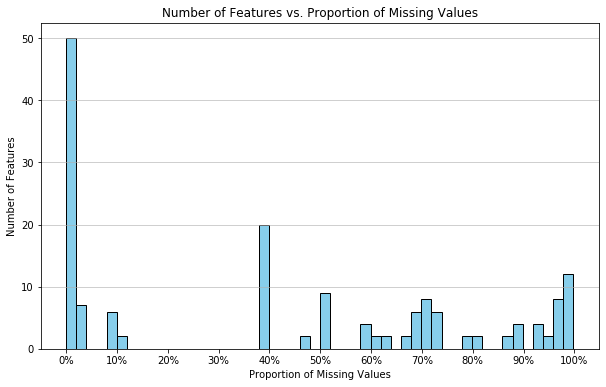

97


In [6]:
# Feature by feature checking

missing_data_summary = df.isnull().mean()
plt.figure(figsize=(10, 6))
plt.hist(missing_data_summary, bins=50, color='skyblue', edgecolor='black')
plt.title('Number of Features vs. Proportion of Missing Values')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Number of Features')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(0, 1.1, 0.1), [f"{x:.0%}" for x in np.arange(0, 1.1, 0.1)])
plt.show()

features_ge_30_missing_count = missing_data_summary[missing_data_summary >= 0.30].count()
print(features_ge_30_missing_count)

In [7]:
# Drop the features with ≥30% missing values & analyse the rest
features_to_drop = missing_data_summary[missing_data_summary >= 0.30].index
data_cleaned = df.drop(columns=features_to_drop)
# (data_cleaned) is dataset in DataFrame that has dropped 97 features with ＞30% missingness

              Feature Data Type  Proportion Missing
0      heart_rate_min   float64            0.001551
1      heart_rate_max   float64            0.001551
2     heart_rate_mean   float64            0.001551
3             sbp_min   float64            0.001905
4             sbp_max   float64            0.001905
5            sbp_mean   float64            0.001905
6             dbp_min   float64            0.001905
7             dbp_max   float64            0.001905
8            dbp_mean   float64            0.001905
9             mbp_min   float64            0.002258
10            mbp_max   float64            0.002258
11           mbp_mean   float64            0.002258
12      resp_rate_min   float64            0.002808
13      resp_rate_max   float64            0.002808
14     resp_rate_mean   float64            0.002808
15    temperature_min   float64            0.032227
16    temperature_max   float64            0.032227
17   temperature_mean   float64            0.032227
18          

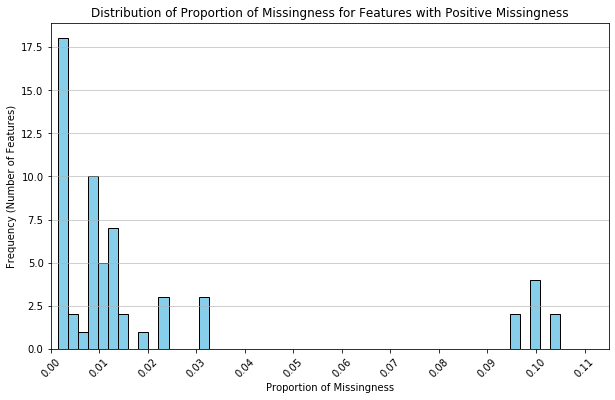

In [8]:
# analyse the rest features with positive missingness
missing_features_cleaned = data_cleaned.columns[data_cleaned.isnull().any()]
missing_features_data_types = data_cleaned[missing_features_cleaned].dtypes
missing_features_proportions = data_cleaned[missing_features_cleaned].isnull().mean()
missing_features_report = pd.DataFrame({
    'Feature': missing_features_cleaned,
    'Data Type': missing_features_data_types.values,
    'Proportion Missing': missing_features_proportions.values})
print(missing_features_report)
# Now, (missing_features_cleaned) contains the 60 features with positive missingness in data_cleaned


min_missingness = missing_features_proportions.min()
max_missingness = missing_features_proportions.max()
print (min_missingness, max_missingness)

plt.figure(figsize=(10, 6))
plt.hist(missing_features_proportions, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Proportion of Missingness for Features with Positive Missingness')
plt.xlabel('Proportion of Missingness')
plt.ylabel('Frequency (Number of Features)')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(0, max_missingness + 0.1, 0.01), rotation=45)
plt.xlim(0, max_missingness + 0.01)
plt.show()

In [9]:
#Implement MICE to the rest features with missingness (missing_features_cleaned)
mice_imputer = IterativeImputer(max_iter=10, random_state=0)

df[missing_features_cleaned] = mice_imputer.fit_transform(df[missing_features_cleaned])

#Check for missing values
missing_values = df.isnull().mean() * 100
columns_with_missing_values = missing_values[missing_values < 0.3]
print(columns_with_missing_values) # Confirm that the features to procceed with have no missingness

id               0.0
aki              0.0
gender           0.0
admission_age    0.0
race             0.0
                ... 
gcs_motor        0.0
gcs_verbal       0.0
gcs_eyes         0.0
gcs_unable       0.0
weight_admit     0.0
Length: 65, dtype: float64


In [10]:
## Data Coding

In [11]:
# For aki, code 0 and 1 into 0 & 2 and 3 into 1
replacements = {0: '0', 1: '0', 2: '1', 3: '1'}
df['aki'] = df['aki'].replace(replacements)
df['aki'] = df['aki'].astype('float64')

In [12]:
# For gender, code F into 0 & M into 1
df['gender'] = df['gender'].replace({'F': '0', 'M': '1'})

df['gender'] = df['gender'].astype('float64')


In [13]:
# For race, consolidate various subcategories into "WHITE", "BLACK", "HISPANIC", "ASIAN", and "OTHERS"

asian_categories = [
    "ASIAN - CHINESE",
    "ASIAN - SOUTH EAST ASIAN",
    "ASIAN - ASIAN INDIAN",
    "ASIAN - KOREAN"]
df['race'] = df['race'].replace(asian_categories, "ASIAN")

white_categories = [
    "WHITE - OTHER EUROPEAN",
    "WHITE - RUSSIAN",
    "WHITE - EASTERN EUROPEAN",
    "WHITE - BRAZILIAN"]
df['race'] = df['race'].replace(white_categories, "WHITE")

black_categories = [
    "BLACK/AFRICAN AMERICAN",
    "BLACK/CAPE VERDEAN",
    "BLACK/CARIBBEAN ISLAND",
    "BLACK/AFRICAN"]
df['race'] = df['race'].replace(black_categories, "BLACK")

hispanic_categories = [
    "HISPANIC/LATINO - CUBAN",
    "HISPANIC/LATINO - COLUMBIAN",
    "HISPANIC/LATINO - HONDURAN",
    "HISPANIC/LATINO - CENTRAL AMERICAN",
    "HISPANIC/LATINO - MEXICAN",
    "HISPANIC/LATINO - SALVADORAN",
    "HISPANIC/LATINO - GUATEMALAN",
    "HISPANIC/LATINO - DOMINICAN",
    "HISPANIC OR LATINO",
    "HISPANIC/LATINO - PUERTO RICAN"]
df['race'] = df['race'].replace(hispanic_categories, "HISPANIC")

preserved_categories = ["WHITE", "BLACK", "ASIAN", "HISPANIC"]
df['race'] = df['race'].apply(lambda x: x if x in preserved_categories else "OTHERS")

# Perform one-hot encoding
race_dummies = pd.get_dummies(df['race'], prefix='race')
df_encoded = pd.concat([df.drop('race', axis=1), race_dummies], axis=1)
print(df_encoded.head())

# Original 160 features = 
# 97 large missingness (dropped) + 60 small missingness + 3 no missingness 
# "race" is replaced by 5 binary columns 
# NOW, 164 features in total = 97 dropped + 67 features to proceed with

# df_encoded is the latest DataFrame

         id  aki  gender  admission_age  heart_rate_min  heart_rate_max  \
0  36570066  1.0     0.0      79.953141            96.0           104.0   
1  39307659  0.0     0.0      78.194169            72.0           134.0   
2  38743306  1.0     0.0      65.602396            60.0            97.0   
3  32339865  1.0     0.0      64.906629            59.0            87.0   
4  35526987  1.0     1.0      57.438861            57.0           100.0   

   heart_rate_mean  sbp_min  sbp_max    sbp_mean  ...  gcs_verbal  gcs_eyes  \
0       100.083333    103.0    126.0  116.136364  ...         5.0       4.0   
1        97.263158     97.0    127.0  109.833333  ...         5.0       4.0   
2        84.166667     95.0    143.0  112.153846  ...         5.0       4.0   
3        71.461538    113.0    150.0  138.160000  ...         0.0       1.0   
4        82.387097     81.0    127.0   97.672131  ...         0.0       1.0   

   gcs_unable  height  weight_admit  race_ASIAN  race_BLACK  race_HISPANIC

In [14]:
## Normalization of features

In [15]:
# Provide summary statistics for non-binary features
non_binary_features = [col for col in df.columns if df[col].nunique() > 2 and col not in ['id', 'aki']]
df_non_binary = df[non_binary_features]
df_no_missing = df_non_binary.dropna(axis=1)
stats_df = df_no_missing.describe().transpose()
stats_df_final = stats_df[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
stats_df_final.reset_index(inplace=True)
stats_df_final.rename(columns={'index': 'Feature'}, inplace=True)
stats_df_final

# 61 numerical features = 67 features - 5 created binary columns - gender

,Feature,mean,std,min,25%,50%,75%,max
0,admission_age,64.942008,17.278264,18.002527,54.503884,66.713334,78.151289,102.865603
1,heart_rate_min,69.903821,15.130207,1.000000,60.000000,69.000000,79.000000,167.000000
2,heart_rate_max,102.494922,20.465651,36.000000,88.000000,100.000000,114.000000,280.000000
3,heart_rate_mean,84.267189,15.714319,28.500000,73.240000,82.800000,94.048214,174.740741
4,sbp_min,93.250167,17.536780,0.108000,83.000000,92.000000,103.000000,195.000000
...,...,...,...,...,...,...,...,...
56,gcs_motor,5.161875,1.660482,1.000000,5.000000,6.000000,6.000000,6.586994
57,gcs_verbal,3.390382,2.081693,0.000000,1.000000,5.000000,5.000000,5.351222
58,gcs_eyes,3.123495,1.104113,0.984404,3.000000,4.000000,4.000000,4.020506
59,gcs_unable,0.205667,0.403243,0.000000,0.000000,0.000000,0.000000,1.000000


In [16]:
# Perform Z-score standardization

df_encoded = df_no_missing.copy()
numerical_features = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
non_binary_numerical = [col for col in numerical_features if df_encoded[col].nunique() > 2 and col not in ['id', 'aki']]
scaler_numerical = StandardScaler()
normalized_data_numerical = scaler_numerical.fit_transform(df_encoded[non_binary_numerical])
df_normalized_numerical = pd.DataFrame(normalized_data_numerical, columns=non_binary_numerical)
df_normalized_numerical.head()

# Now the latest dataframe is df_normalized_numerical.

,admission_age,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,...,pt_min,pt_max,ptt_min,ptt_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,weight_admit
0,0.868796,1.724790,0.073542,1.006490,0.555970,-0.978730,-0.181313,-0.625182,-1.544726,-1.419187,...,-0.447619,-0.454832,-0.225154,-0.448500,0.490659,0.504753,0.773233,0.793862,-0.510038,0.793340
1,0.766992,0.138544,1.539428,0.827023,0.213829,-0.934710,-0.566560,0.738381,0.032259,0.556649,...,1.034825,0.817404,-0.242911,3.908433,0.490659,0.504753,0.773233,0.793862,-0.510038,0.012473
2,0.038221,-0.654579,-0.268498,-0.006397,0.099782,-0.230398,-0.424728,0.738381,0.540964,0.834914,...,-0.411015,-0.444814,-0.455987,-0.575050,0.490659,0.504753,0.773233,0.793862,-0.510038,-0.542500
3,-0.002048,-0.720673,-0.757126,-0.814911,1.126206,0.077738,1.164789,1.079272,0.286612,1.445506,...,-0.282903,-0.374691,-0.447109,-0.571434,0.490659,-2.506450,-1.628682,-1.923277,1.969878,0.879793
4,-0.434258,-0.852860,-0.121909,-0.119643,-0.698548,-0.934710,-1.309862,-0.028623,0.337482,-0.182089,...,-0.722146,-0.464850,-0.305058,-0.090545,0.490659,-1.494232,-1.628682,-1.923277,1.969878,0.441950


In [17]:
## Identify the outliers (>3 s.d.) 


outliers_numerical_info = pd.DataFrame()
for feature in df_normalized_numerical.columns:
    outliers_mask_numerical = df_normalized_numerical[feature].abs() > 3
    outliers_numerical = df_normalized_numerical[outliers_mask_numerical][feature]
    
    # Categorize the exceed amounts into the defined bins
    bins = [3, 3.5, 4, 5, float('inf')]
    labels = ['3-3.5', '3.5-4', '4-5', 'Above 5']
    outliers_numerical_df = pd.DataFrame(outliers_numerical)
    outliers_numerical_df['Value Range'] = pd.cut(outliers_numerical_df[feature].abs(), bins=bins, labels=labels, right=False)
    
    summary = outliers_numerical_df['Value Range'].value_counts().reset_index()
    summary.columns = ['Value Range', 'Frequency']
    summary['Feature'] = feature
    
    outliers_numerical_info = pd.concat([outliers_numerical_info, summary], axis=0)

# Aggregate the results to present frequency and value range for all features
outliers_summary_table = outliers_numerical_info.groupby(['Value Range']).sum().reset_index()[['Value Range', 'Frequency']]
outliers_summary_table




,Value Range,Frequency
0,3-3.5,12582
1,3.5-4,8550
2,4-5,7622
3,Above 5,6492


In [18]:
## Identify the outliers (>3 s.d.) 


outliers_numerical_info = pd.DataFrame()
for feature in df_normalized_numerical.columns:
    outliers_mask_numerical = df_normalized_numerical[feature].abs() > 3
    outliers_numerical = df_normalized_numerical[outliers_mask_numerical][feature]
    
    bins = [3, 3.5, 4, 5, float('inf')]
    labels = ['3-3.5', '3.5-4', '4-5', 'Above 5']
    outliers_numerical_df = pd.DataFrame(outliers_numerical)
    outliers_numerical_df['Value Range'] = pd.cut(outliers_numerical_df[feature].abs(), bins=bins, labels=labels, right=False)
    
    # Summarize the frequency of exceed amounts within the specified value ranges
    summary = outliers_numerical_df['Value Range'].value_counts().reset_index()
    summary.columns = ['Value Range', 'Frequency']
    summary['Feature'] = feature
    
    outliers_numerical_info = pd.concat([outliers_numerical_info, summary], axis=0)


outliers_summary_table = outliers_numerical_info.groupby(['Value Range']).sum().reset_index()[['Value Range', 'Frequency']]
outliers_summary_table

,Value Range,Frequency
0,3-3.5,12582
1,3.5-4,8550
2,4-5,7622
3,Above 5,6492


In [19]:
outlier_counts = df_normalized_numerical.apply(lambda x: (np.abs(x) > 3).sum())
outlier_counts = outlier_counts[outlier_counts > 0]
outlier_counts_df = pd.DataFrame(outlier_counts).reset_index()
outlier_counts_df.columns = ['Feature', 'Number of Outliers']
outlier_counts_df.sort_values('Number of Outliers', ascending=False, inplace=True)
print(outlier_counts_df)

              Feature  Number of Outliers
53            ptt_max                2271
54            gcs_min                1751
36            bun_min                1206
37            bun_max                1176
44       sodium_min.1                 972
50             pt_min                 962
47    potassium_max.1                 949
48            inr_min                 928
33       aniongap_max                 918
42      glucose_min.2                 917
52            ptt_min                 905
18           spo2_min                 903
43      glucose_max.2                 901
51             pt_max                 869
34  bicarbonate_min.1                 854
49            inr_max                 849
45       sodium_max.1                 835
10            mbp_max                 821
9             mbp_min                 803
15    temperature_min                 786
16    temperature_max                 750
40     chloride_min.1                 702
35  bicarbonate_max.1             

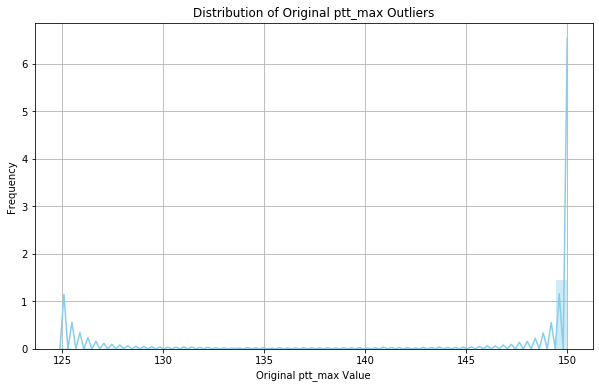

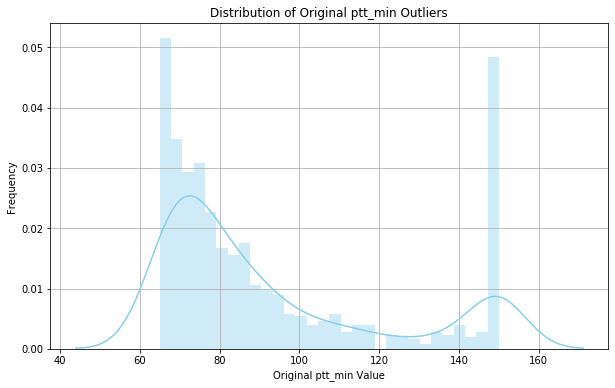

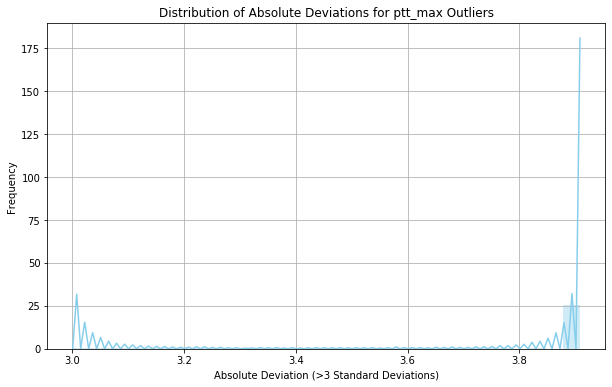

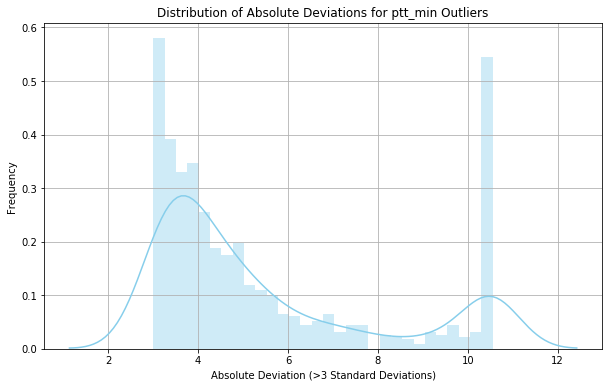

In [20]:
# For ptt_min and ptt_max:
# Original value:
outlier_indices = df_normalized_numerical['ptt_max'][np.abs(df_normalized_numerical['ptt_max']) > 3].index
ptt_max_outliers_original = df_encoded.loc[outlier_indices, 'ptt_max']
plt.figure(figsize=(10, 6))
sns.distplot(ptt_max_outliers_original, kde=True, color='skyblue')
plt.title('Distribution of Original ptt_max Outliers')
plt.xlabel('Original ptt_max Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

outlier_indices_ptt_min = df_normalized_numerical['ptt_min'][np.abs(df_normalized_numerical['ptt_min']) > 3].index
ptt_min_outliers_original = df_encoded.loc[outlier_indices_ptt_min, 'ptt_min']
plt.figure(figsize=(10, 6))
sns.distplot(ptt_min_outliers_original, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Original ptt_min Outliers')
plt.xlabel('Original ptt_min Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

ptt_max_outliers = df_normalized_numerical['ptt_max'][np.abs(df_normalized_numerical['ptt_max']) > 3]
ptt_max_outliers_deviation_abs = np.abs(ptt_max_outliers)
plt.figure(figsize=(10, 6))
sns.distplot(ptt_max_outliers_deviation_abs, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Absolute Deviations for ptt_max Outliers')
plt.xlabel('Absolute Deviation (>3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


ptt_min_outliers = df_normalized_numerical['ptt_min'][np.abs(df_normalized_numerical['ptt_min']) > 3]
ptt_min_outliers_deviation_abs = np.abs(ptt_min_outliers)
plt.figure(figsize=(10, 6))
sns.distplot(ptt_min_outliers_deviation_abs, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Absolute Deviations for ptt_min Outliers')
plt.xlabel('Absolute Deviation (>3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


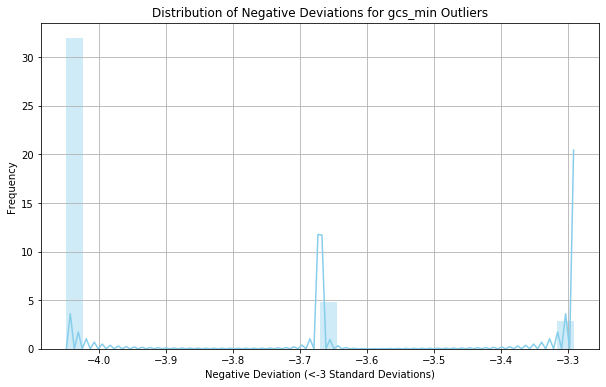

In [21]:
# For gcs_min
gcs_min_negative_outliers = df_normalized_numerical['gcs_min'][df_normalized_numerical['gcs_min'] < -3]
plt.figure(figsize=(10, 6))
sns.distplot(gcs_min_negative_outliers, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Negative Deviations for gcs_min Outliers')
plt.xlabel('Negative Deviation (<-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

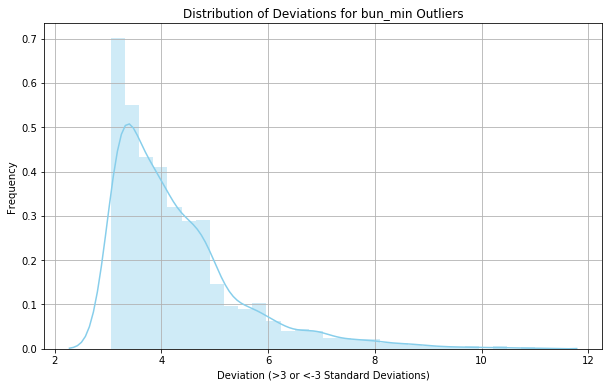

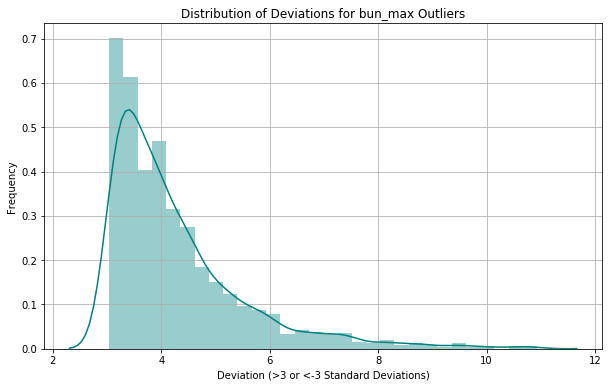

In [22]:
# For bun_min and bun_max

bun_min_outliers_deviation = df_normalized_numerical['bun_min'][np.abs(df_normalized_numerical['bun_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(bun_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for bun_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


bun_max_outliers_deviation = df_normalized_numerical['bun_max'][np.abs(df_normalized_numerical['bun_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(bun_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for bun_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


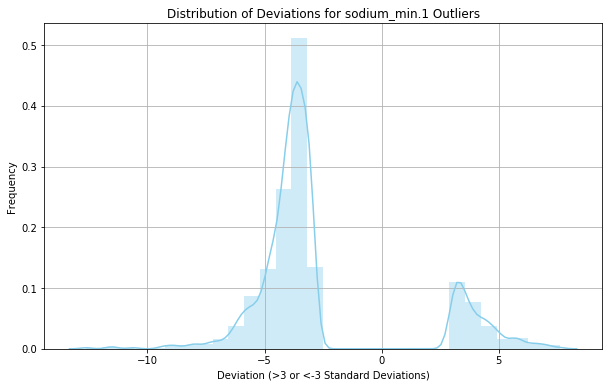

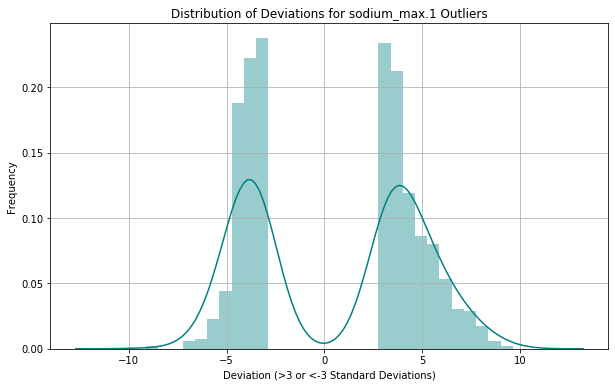

In [23]:
# For sodium_min.1 and sodium_max.1

sodium_min_1_outliers_deviation = df_normalized_numerical['sodium_min.1'][np.abs(df_normalized_numerical['sodium_min.1']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(sodium_min_1_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for sodium_min.1 Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


sodium_max_1_outliers_deviation = df_normalized_numerical['sodium_max.1'][np.abs(df_normalized_numerical['sodium_max.1']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(sodium_max_1_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for sodium_max.1 Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


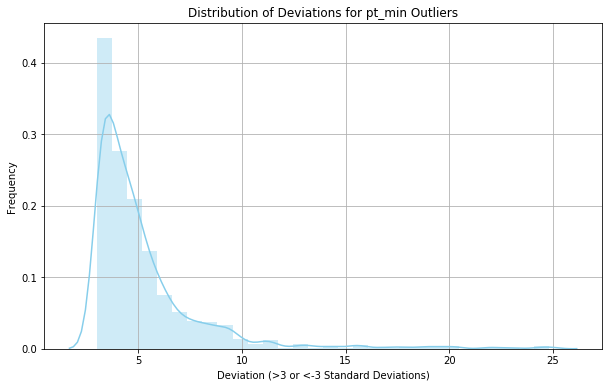

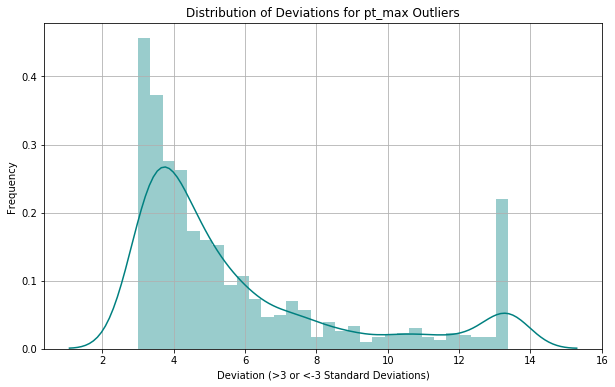

In [24]:
# For pt_min and pt_max

pt_min_outliers_deviation = df_normalized_numerical['pt_min'][np.abs(df_normalized_numerical['pt_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(pt_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for pt_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


pt_max_outliers_deviation = df_normalized_numerical['pt_max'][np.abs(df_normalized_numerical['pt_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(pt_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for pt_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


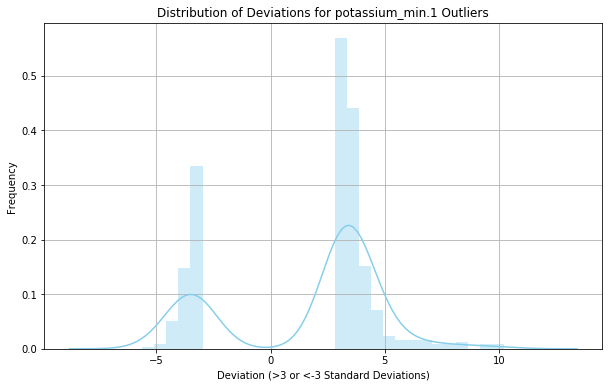

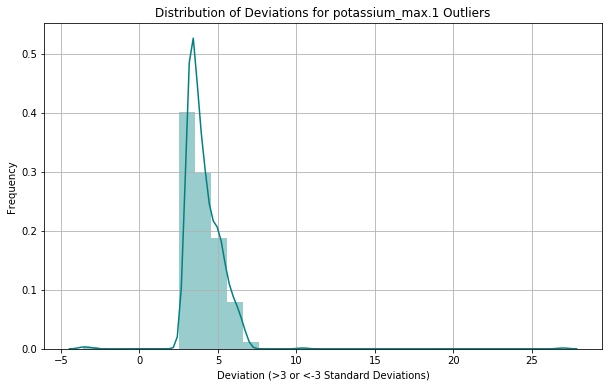

In [25]:
# For potassium_max.1 and potassium_min.1 
potassium_min_1_outliers_deviation = df_normalized_numerical['potassium_min.1'][np.abs(df_normalized_numerical['potassium_min.1']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(potassium_min_1_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for potassium_min.1 Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

potassium_max_1_outliers_deviation = df_normalized_numerical['potassium_max.1'][np.abs(df_normalized_numerical['potassium_max.1']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(potassium_max_1_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for potassium_max.1 Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


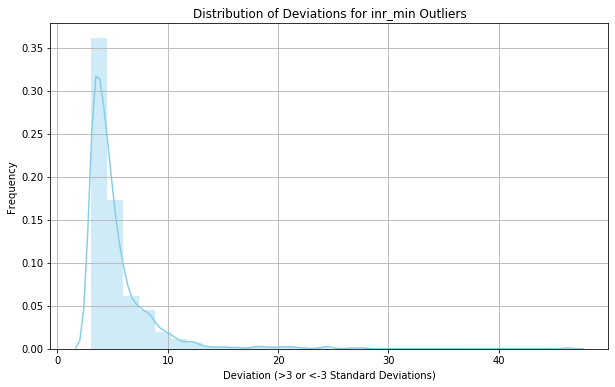

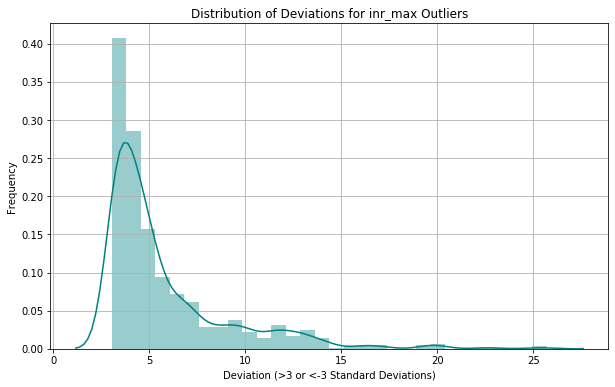

In [26]:
# For inr-min and inr-max
import matplotlib.pyplot as plt
import seaborn as sns

# Identify the outliers for 'inr_min' that exceed 3 standard deviations from the mean
inr_min_outliers_deviation = df_normalized_numerical['inr_min'][np.abs(df_normalized_numerical['inr_min']) > 3]

# Plot the distribution of deviations for 'inr_min' outliers
plt.figure(figsize=(10, 6))
sns.distplot(inr_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for inr_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Identify the outliers for 'inr_max' that exceed 3 standard deviations from the mean
inr_max_outliers_deviation = df_normalized_numerical['inr_max'][np.abs(df_normalized_numerical['inr_max']) > 3]

# Plot the distribution of deviations for 'inr_max' outliers
plt.figure(figsize=(10, 6))
sns.distplot(inr_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for inr_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


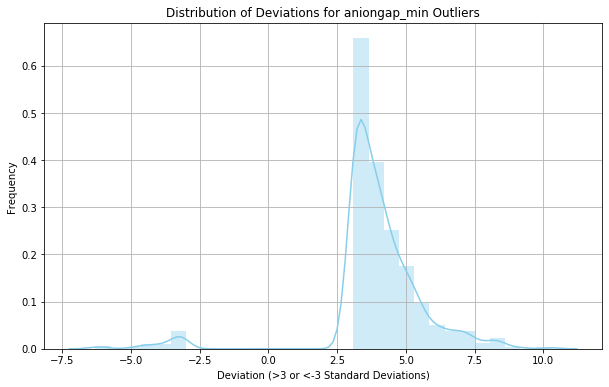

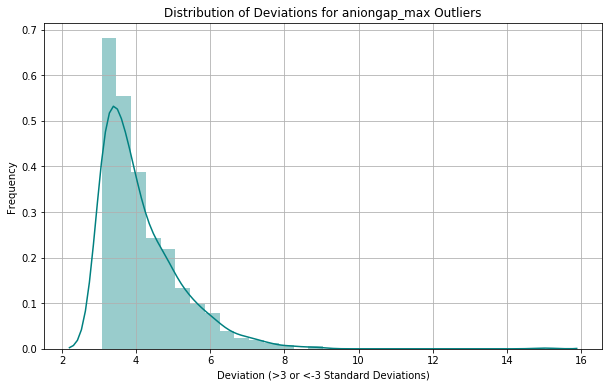

In [27]:
# For aniongap_max and aniongap_min

import matplotlib.pyplot as plt
import seaborn as sns

# Identify the outliers for 'aniongap_min' that exceed 3 standard deviations from the mean
aniongap_min_outliers_deviation = df_normalized_numerical['aniongap_min'][np.abs(df_normalized_numerical['aniongap_min']) > 3]

# Plot the distribution of deviations for 'aniongap_min' outliers
plt.figure(figsize=(10, 6))
sns.distplot(aniongap_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for aniongap_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Identify the outliers for 'aniongap_max' that exceed 3 standard deviations from the mean
aniongap_max_outliers_deviation = df_normalized_numerical['aniongap_max'][np.abs(df_normalized_numerical['aniongap_max']) > 3]

# Plot the distribution of deviations for 'aniongap_max' outliers
plt.figure(figsize=(10, 6))
sns.distplot(aniongap_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for aniongap_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


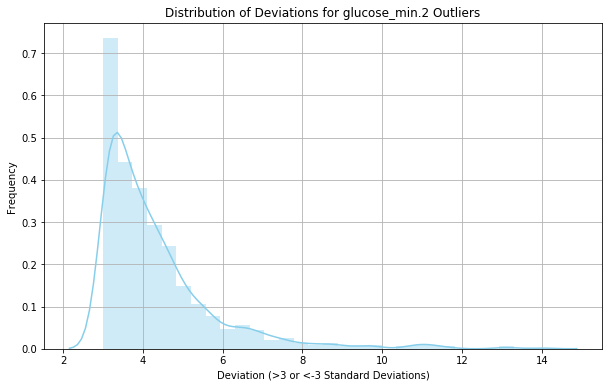

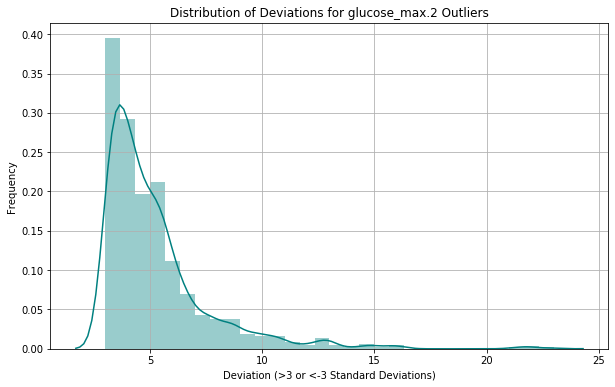

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


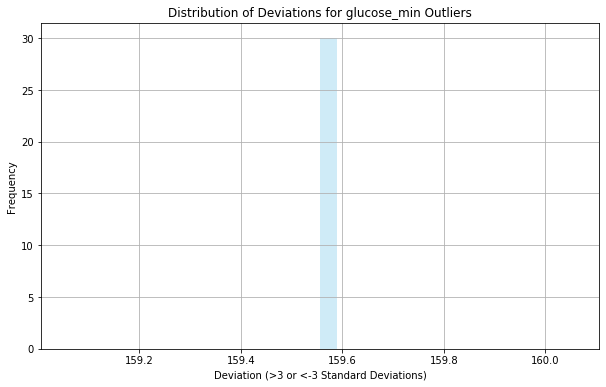

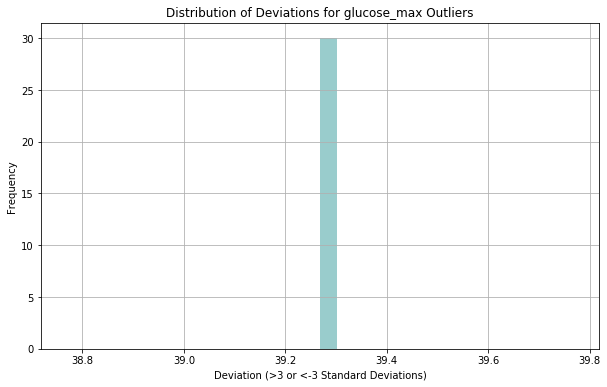

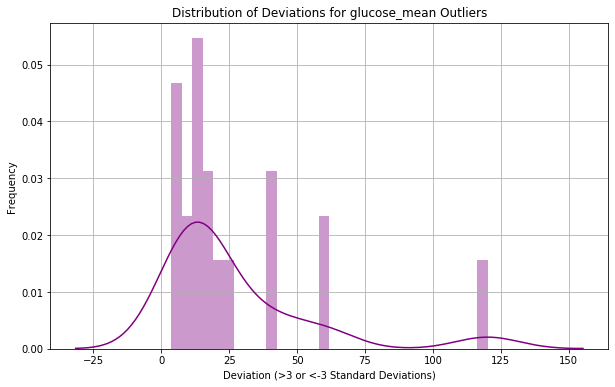

In [28]:
# For glucose related

glucose_min_2_outliers_deviation = df_normalized_numerical['glucose_min.2'][np.abs(df_normalized_numerical['glucose_min.2']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(glucose_min_2_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for glucose_min.2 Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

glucose_max_2_outliers_deviation = df_normalized_numerical['glucose_max.2'][np.abs(df_normalized_numerical['glucose_max.2']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(glucose_max_2_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for glucose_max.2 Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

glucose_min_outliers_deviation = df_normalized_numerical['glucose_min'][np.abs(df_normalized_numerical['glucose_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(glucose_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for glucose_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

glucose_max_outliers_deviation = df_normalized_numerical['glucose_max'][np.abs(df_normalized_numerical['glucose_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(glucose_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for glucose_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

glucose_mean_outliers_deviation = df_normalized_numerical['glucose_mean'][np.abs(df_normalized_numerical['glucose_mean']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(glucose_mean_outliers_deviation, bins=30, kde=True, color='purple')
plt.title('Distribution of Deviations for glucose_mean Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


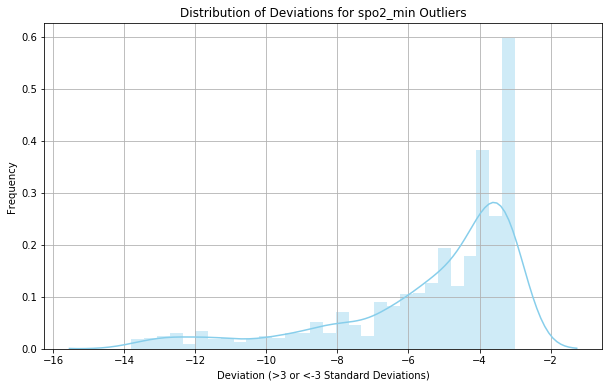

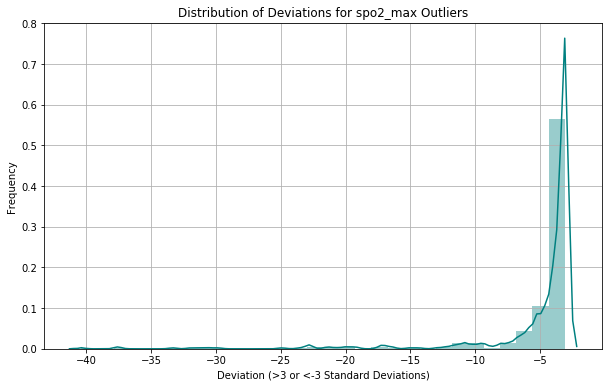

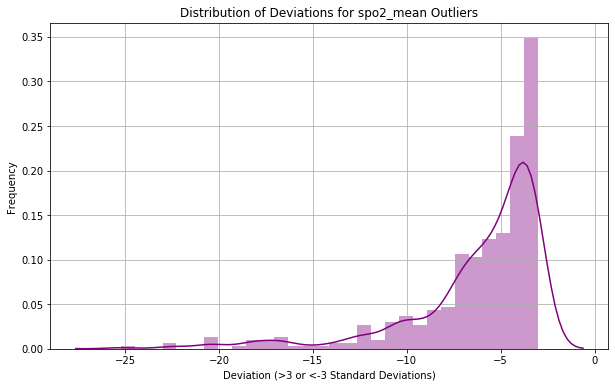

In [29]:
# For spo2_min and spo2_max and spo2_mean

spo2_min_outliers_deviation = df_normalized_numerical['spo2_min'][np.abs(df_normalized_numerical['spo2_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(spo2_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for spo2_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


spo2_max_outliers_deviation = df_normalized_numerical['spo2_max'][np.abs(df_normalized_numerical['spo2_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(spo2_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for spo2_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


spo2_mean_outliers_deviation = df_normalized_numerical['spo2_mean'][np.abs(df_normalized_numerical['spo2_mean']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(spo2_mean_outliers_deviation, bins=30, kde=True, color='purple')
plt.title('Distribution of Deviations for spo2_mean Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


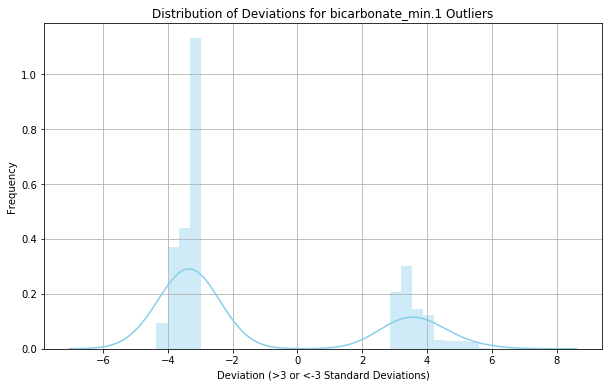

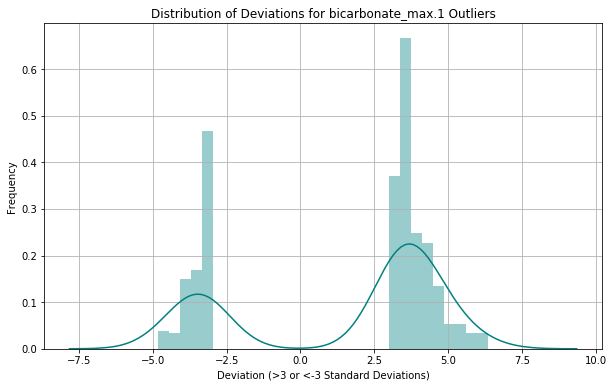

In [30]:
# For bicarbonate_min_1 and bicarbonate_max_1

bicarbonate_min_1_outliers_deviation = df_normalized_numerical['bicarbonate_min.1'][np.abs(df_normalized_numerical['bicarbonate_min.1']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(bicarbonate_min_1_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for bicarbonate_min.1 Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

bicarbonate_max_1_outliers_deviation = df_normalized_numerical['bicarbonate_max.1'][np.abs(df_normalized_numerical['bicarbonate_max.1']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(bicarbonate_max_1_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for bicarbonate_max.1 Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



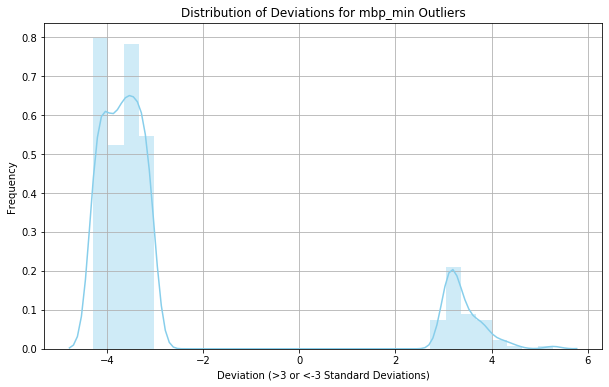

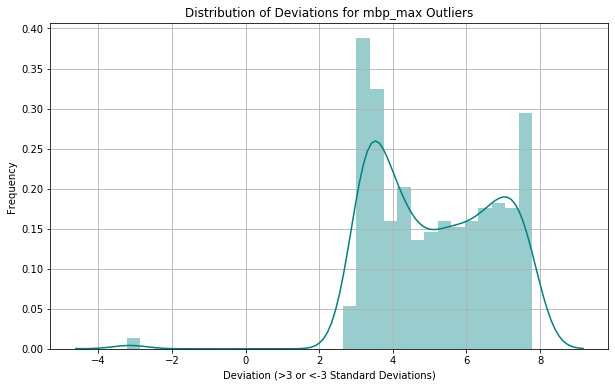

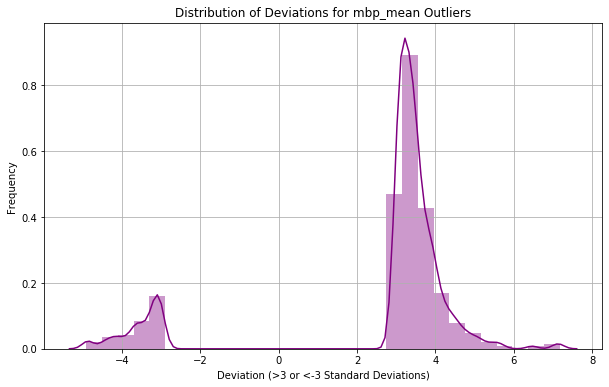

In [31]:
# For mbp

mbp_min_outliers_deviation = df_normalized_numerical['mbp_min'][np.abs(df_normalized_numerical['mbp_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(mbp_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for mbp_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


mbp_max_outliers_deviation = df_normalized_numerical['mbp_max'][np.abs(df_normalized_numerical['mbp_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(mbp_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for mbp_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


mbp_mean_outliers_deviation = df_normalized_numerical['mbp_mean'][np.abs(df_normalized_numerical['mbp_mean']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(mbp_mean_outliers_deviation, bins=30, kde=True, color='purple')
plt.title('Distribution of Deviations for mbp_mean Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


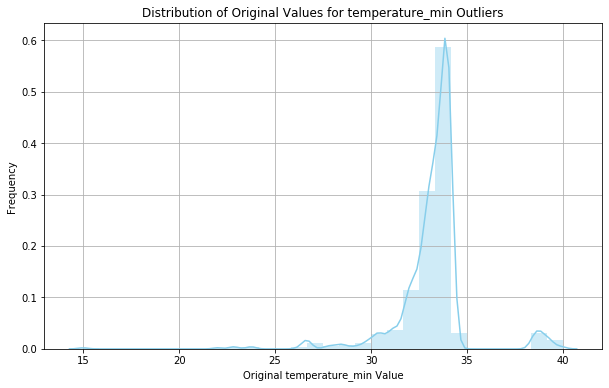

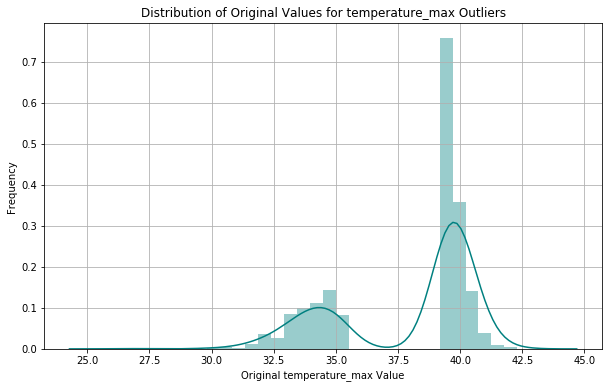

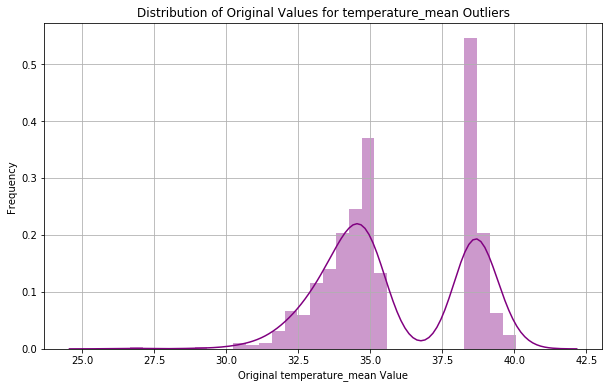

In [33]:
# For temperature_min, temperature_max, and temperature_mean


temperature_min_outliers_indices = df_normalized_numerical['temperature_min'][np.abs(df_normalized_numerical['temperature_min']) > 3].index
temperature_min_outliers_original = df_encoded.loc[temperature_min_outliers_indices, 'temperature_min']
plt.figure(figsize=(10, 6))
sns.distplot(temperature_min_outliers_original, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Original Values for temperature_min Outliers')
plt.xlabel('Original temperature_min Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


temperature_max_outliers_indices = df_normalized_numerical['temperature_max'][np.abs(df_normalized_numerical['temperature_max']) > 3].index
temperature_max_outliers_original = df_encoded.loc[temperature_max_outliers_indices, 'temperature_max']
plt.figure(figsize=(10, 6))
sns.distplot(temperature_max_outliers_original, bins=30, kde=True, color='teal')
plt.title('Distribution of Original Values for temperature_max Outliers')
plt.xlabel('Original temperature_max Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

temperature_mean_outliers_indices = df_normalized_numerical['temperature_mean'][np.abs(df_normalized_numerical['temperature_mean']) > 3].index
temperature_mean_outliers_original = df_encoded.loc[temperature_mean_outliers_indices, 'temperature_mean']
plt.figure(figsize=(10, 6))
sns.distplot(temperature_mean_outliers_original, bins=30, kde=True, color='purple')
plt.title('Distribution of Original Values for temperature_mean Outliers')
plt.xlabel('Original temperature_mean Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


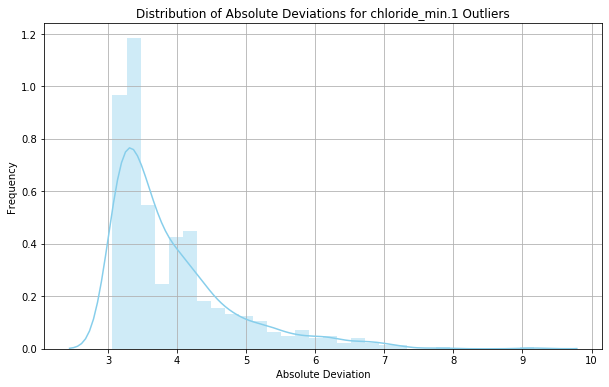

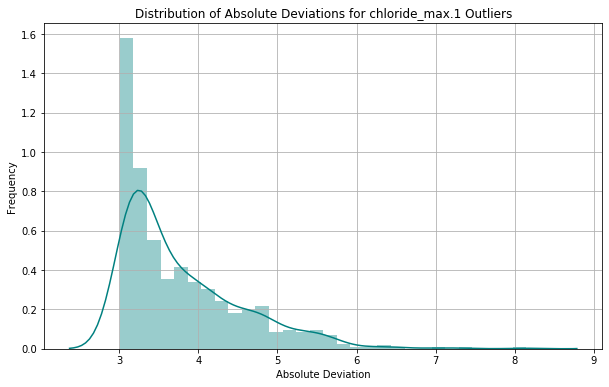

In [34]:
#For chloride_min.and chloride_max.1

chloride_min_1_outliers_deviation = df_normalized_numerical['chloride_min.1'][np.abs(df_normalized_numerical['chloride_min.1']) > 3].abs()
plt.figure(figsize=(10, 6))
sns.distplot(chloride_min_1_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Absolute Deviations for chloride_min.1 Outliers')
plt.xlabel('Absolute Deviation')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

chloride_max_1_outliers_deviation = df_normalized_numerical['chloride_max.1'][np.abs(df_normalized_numerical['chloride_max.1']) > 3].abs()
plt.figure(figsize=(10, 6))
sns.distplot(chloride_max_1_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Absolute Deviations for chloride_max.1 Outliers')
plt.xlabel('Absolute Deviation')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


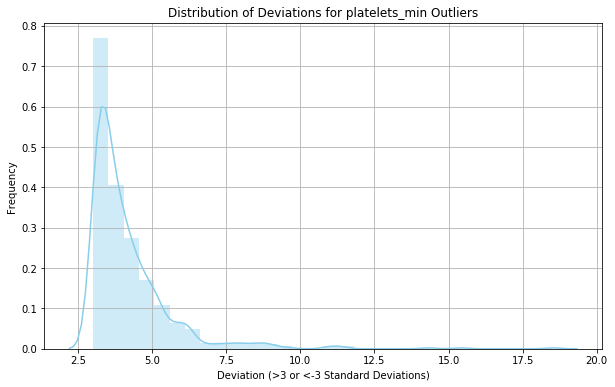

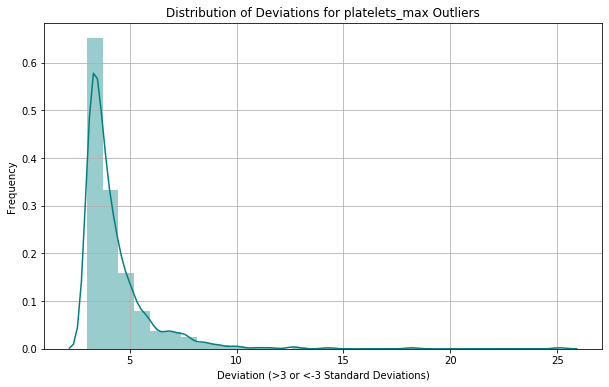

In [35]:
# For platelets_min and platelets_max


platelets_min_outliers_deviation = df_normalized_numerical['platelets_min'][np.abs(df_normalized_numerical['platelets_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(platelets_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for platelets_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


platelets_max_outliers_deviation = df_normalized_numerical['platelets_max'][np.abs(df_normalized_numerical['platelets_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(platelets_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for platelets_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


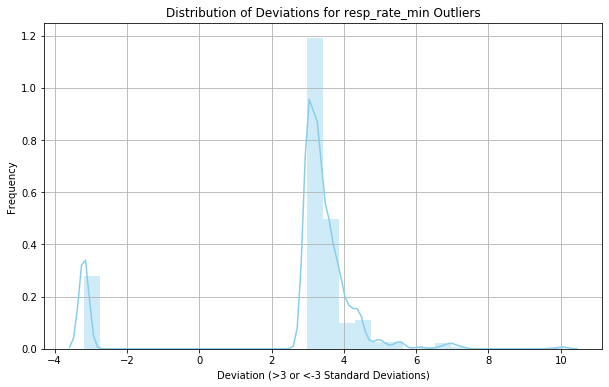

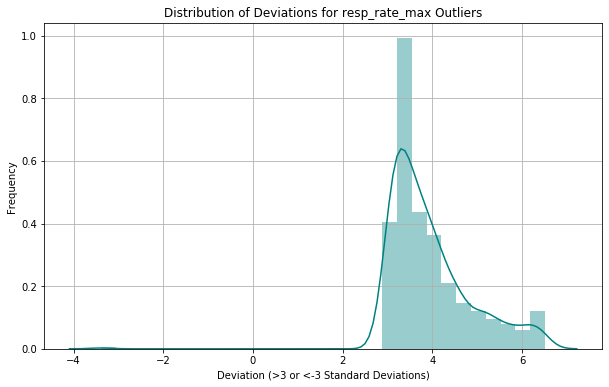

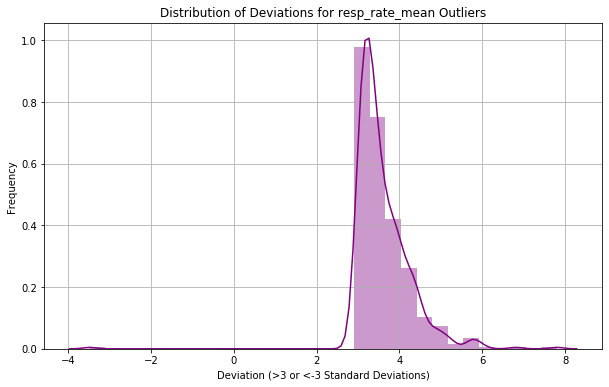

In [36]:
# For resp_rate_max, resp_rate_min and resp_rate_mean


resp_rate_min_outliers_deviation = df_normalized_numerical['resp_rate_min'][np.abs(df_normalized_numerical['resp_rate_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(resp_rate_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for resp_rate_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


resp_rate_max_outliers_deviation = df_normalized_numerical['resp_rate_max'][np.abs(df_normalized_numerical['resp_rate_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(resp_rate_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for resp_rate_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


resp_rate_mean_outliers_deviation = df_normalized_numerical['resp_rate_mean'][np.abs(df_normalized_numerical['resp_rate_mean']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(resp_rate_mean_outliers_deviation, bins=30, kde=True, color='purple')
plt.title('Distribution of Deviations for resp_rate_mean Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



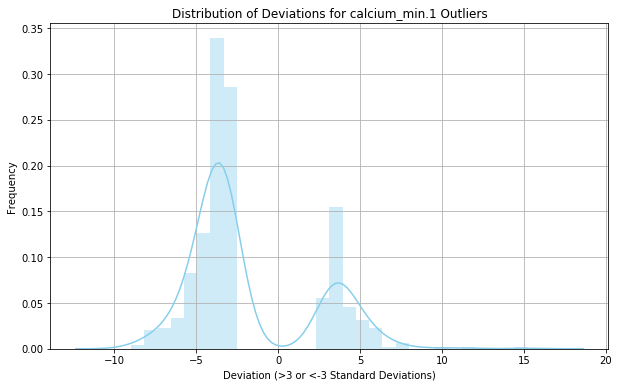

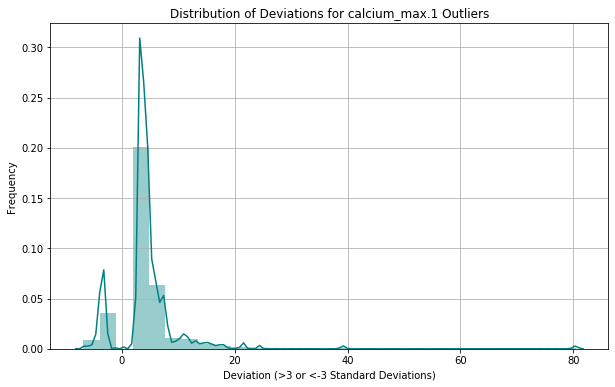

In [37]:
# For  calcium_min.1  and  calcium_max.1 


calcium_min_1_outliers_deviation = df_normalized_numerical['calcium_min.1'][np.abs(df_normalized_numerical['calcium_min.1']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(calcium_min_1_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for calcium_min.1 Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


calcium_max_1_outliers_deviation = df_normalized_numerical['calcium_max.1'][np.abs(df_normalized_numerical['calcium_max.1']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(calcium_max_1_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for calcium_max.1 Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


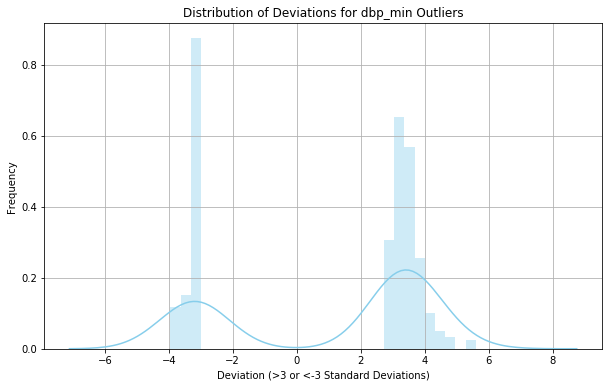

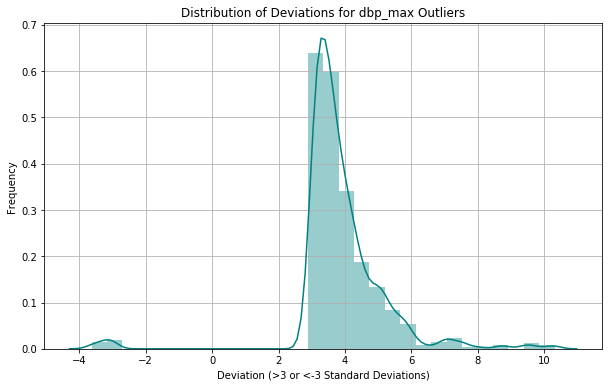

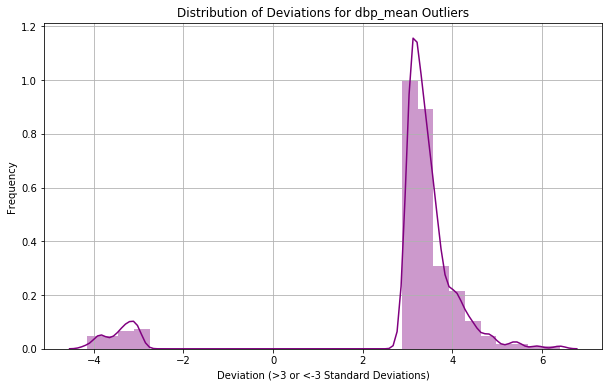

In [38]:
# For dbp_min, dbp_max and dbp_mean

dbp_min_outliers_deviation = df_normalized_numerical['dbp_min'][np.abs(df_normalized_numerical['dbp_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(dbp_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for dbp_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


dbp_max_outliers_deviation = df_normalized_numerical['dbp_max'][np.abs(df_normalized_numerical['dbp_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(dbp_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for dbp_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


dbp_mean_outliers_deviation = df_normalized_numerical['dbp_mean'][np.abs(df_normalized_numerical['dbp_mean']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(dbp_mean_outliers_deviation, bins=30, kde=True, color='purple')
plt.title('Distribution of Deviations for dbp_mean Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


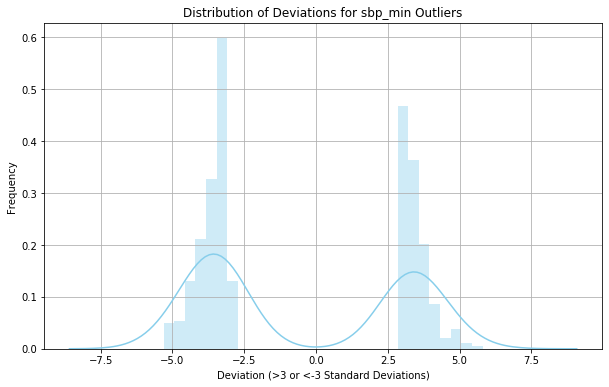

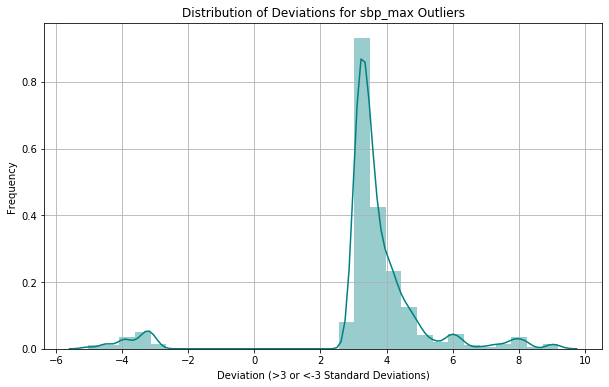

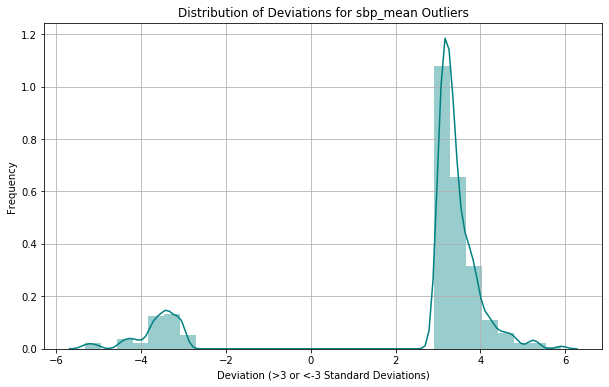

In [39]:
# For sbp_min, sbp_max, and sbp_mean

sbp_min_outliers_deviation = df_normalized_numerical['sbp_min'][np.abs(df_normalized_numerical['sbp_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(sbp_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for sbp_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


sbp_max_outliers_deviation = df_normalized_numerical['sbp_max'][np.abs(df_normalized_numerical['sbp_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(sbp_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for sbp_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


sbp_mean_outliers_deviation = df_normalized_numerical['sbp_mean'][np.abs(df_normalized_numerical['sbp_mean']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(sbp_mean_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for sbp_mean Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


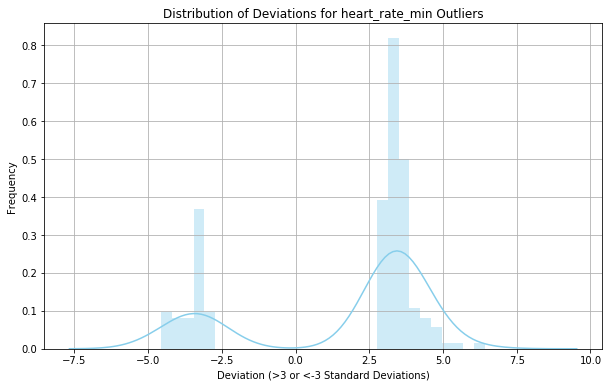

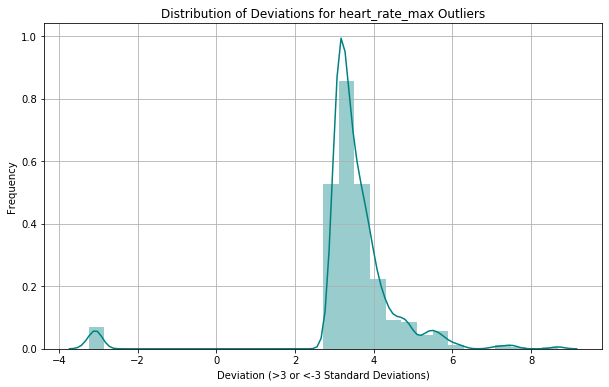

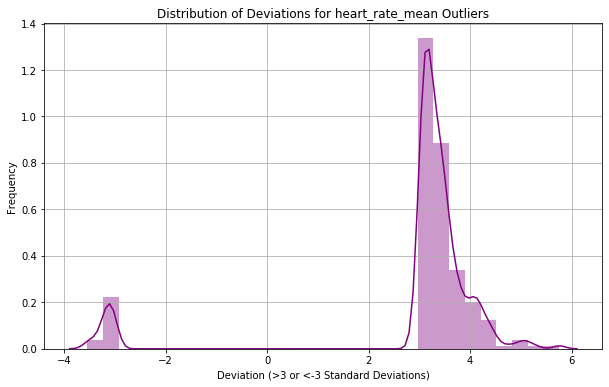

In [40]:
# For heart_rate_max, heart_rate_min, and heart_rate_mean

heart_rate_min_outliers_deviation = df_normalized_numerical['heart_rate_min'][np.abs(df_normalized_numerical['heart_rate_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(heart_rate_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for heart_rate_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


heart_rate_max_outliers_deviation = df_normalized_numerical['heart_rate_max'][np.abs(df_normalized_numerical['heart_rate_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(heart_rate_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for heart_rate_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


heart_rate_mean_outliers_deviation = df_normalized_numerical['heart_rate_mean'][np.abs(df_normalized_numerical['heart_rate_mean']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(heart_rate_mean_outliers_deviation, bins=30, kde=True, color='purple')
plt.title('Distribution of Deviations for heart_rate_mean Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




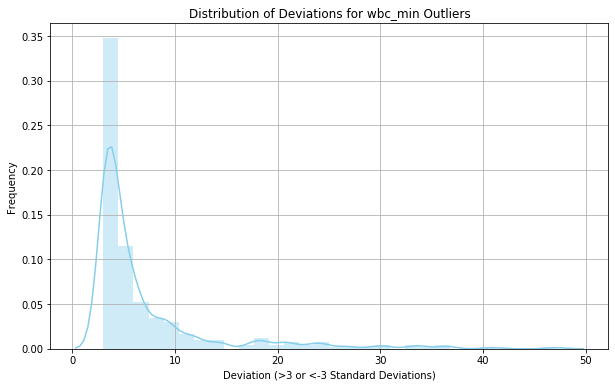

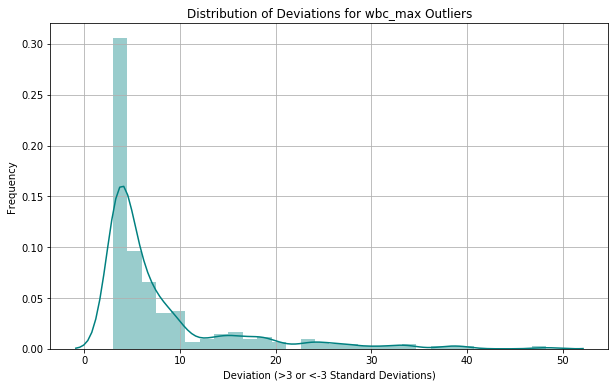

In [41]:
# For wbc_min and wbc_max

wbc_min_outliers_deviation = df_normalized_numerical['wbc_min'][np.abs(df_normalized_numerical['wbc_min']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(wbc_min_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for wbc_min Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


wbc_max_outliers_deviation = df_normalized_numerical['wbc_max'][np.abs(df_normalized_numerical['wbc_max']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(wbc_max_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for wbc_max Outliers')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


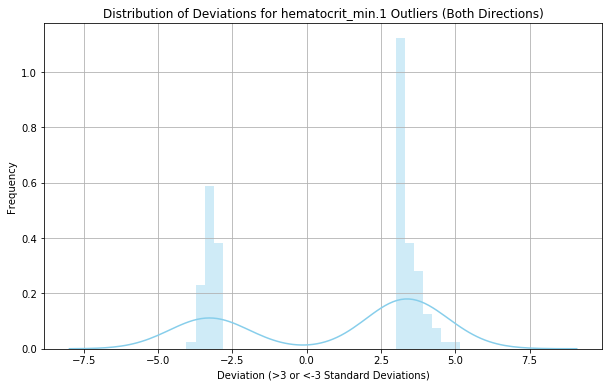

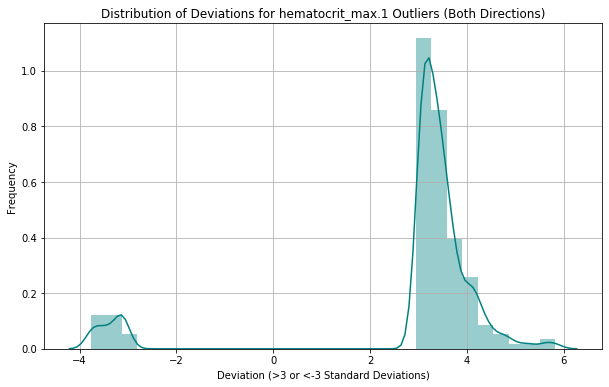

In [42]:
# For hematocrit_max.1 and hematocrit_min.1

hematocrit_min_1_outliers_deviation = df_normalized_numerical['hematocrit_min.1'][np.abs(df_normalized_numerical['hematocrit_min.1']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(hematocrit_min_1_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for hematocrit_min.1 Outliers (Both Directions)')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

hematocrit_max_1_outliers_deviation = df_normalized_numerical['hematocrit_max.1'][np.abs(df_normalized_numerical['hematocrit_max.1']) > 3]
plt.figure(figsize=(10, 6))
sns.distplot(hematocrit_max_1_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for hematocrit_max.1 Outliers (Both Directions)')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


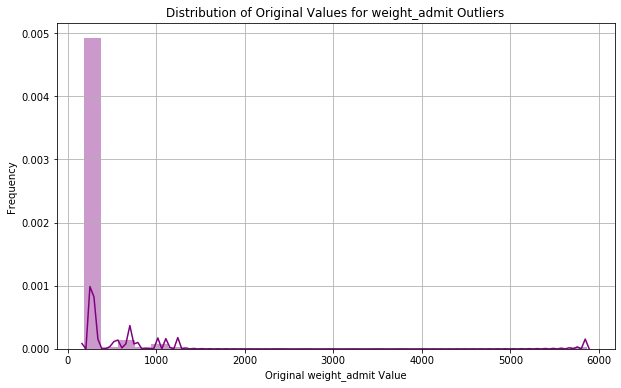

  Value Range  Frequency
0      50-100          0
1     100-200         29
2     200-250         92
3   Above 250         23


In [43]:
# For weight_admit

weight_admit_outliers_indices = df_normalized_numerical['weight_admit'][np.abs(df_normalized_numerical['weight_admit']) > 3].index
weight_admit_outliers_original = df_encoded.loc[weight_admit_outliers_indices, 'weight_admit']
plt.figure(figsize=(10, 6))
sns.distplot(weight_admit_outliers_original, bins=30, kde=True, color='purple')
plt.title('Distribution of Original Values for weight_admit Outliers')
plt.xlabel('Original weight_admit Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Define the new value ranges
bins = [50, 100, 200, 250, float('inf')]
labels = ['50-100', '100-200', '200-250', 'Above 250']

# Categorize the outlier values into the defined bins
weight_admit_outliers_binned = pd.cut(weight_admit_outliers_original, bins=bins, labels=labels, right=False)

# Calculate the frequency of outliers in each range
weight_admit_outliers_frequency = weight_admit_outliers_binned.value_counts().sort_index()

# Convert the frequency data to a DataFrame for display
weight_admit_outliers_table = weight_admit_outliers_frequency.reset_index()
weight_admit_outliers_table.columns = ['Value Range', 'Frequency']


print(weight_admit_outliers_table)

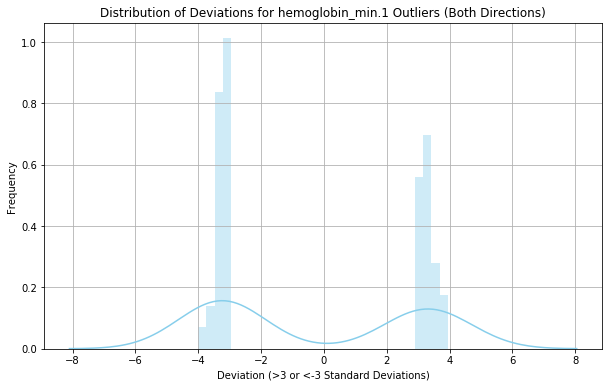

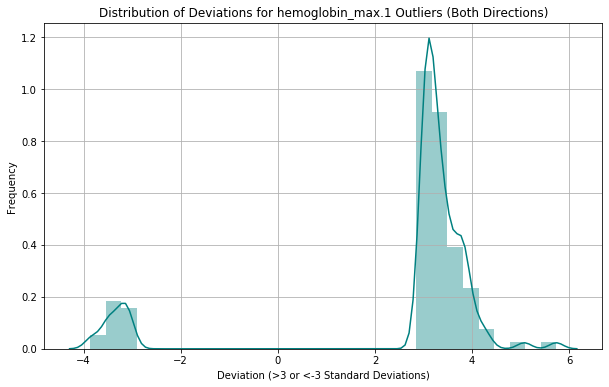

In [44]:
# For hemoglobin_min.1 and hemoglobin_max.1
import matplotlib.pyplot as plt
import seaborn as sns

# Identify the deviations for 'hemoglobin_min.1' outliers
hemoglobin_min_1_outliers_deviation = df_normalized_numerical['hemoglobin_min.1'][np.abs(df_normalized_numerical['hemoglobin_min.1']) > 3]

# Plot the distribution of deviations for 'hemoglobin_min.1' outliers, showing both directions
plt.figure(figsize=(10, 6))
sns.distplot(hemoglobin_min_1_outliers_deviation, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Deviations for hemoglobin_min.1 Outliers (Both Directions)')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Identify the deviations for 'hemoglobin_max.1' outliers
hemoglobin_max_1_outliers_deviation = df_normalized_numerical['hemoglobin_max.1'][np.abs(df_normalized_numerical['hemoglobin_max.1']) > 3]

# Plot the distribution of deviations for 'hemoglobin_max.1' outliers, showing both directions
plt.figure(figsize=(10, 6))
sns.distplot(hemoglobin_max_1_outliers_deviation, bins=30, kde=True, color='teal')
plt.title('Distribution of Deviations for hemoglobin_max.1 Outliers (Both Directions)')
plt.xlabel('Deviation (>3 or <-3 Standard Deviations)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [45]:
# Remove outliers in the dataframe "df_encoded"

# For 'glucose_min', 'glucose_max', 'glucose_mean'
for feature in ['glucose_min', 'glucose_max', 'glucose_mean']:
    mean = df_encoded[feature].mean()
    std = df_encoded[feature].std()
    upper_limit = mean + 3 * std
    lower_limit = mean - 3 * std
    df_encoded.loc[df_encoded[feature] > upper_limit, feature] = np.nan
    df_encoded.loc[df_encoded[feature] < lower_limit, feature] = np.nan
    

# For 'temperature_min', 'temperature_max', 'temperature_mean'
features_temp = ['temperature_min', 'temperature_max', 'temperature_mean']
for feature in features_temp:
    mean = df_encoded[feature].mean()
    std = df_encoded[feature].std()
    lower_limit = mean - 3 * std
    df_encoded.loc[df_encoded[feature] < lower_limit, feature] = np.nan


# Replace values greater than 250 in 'weight_admit' with NaN
df_encoded.loc[df_encoded['weight_admit'] >= 250, 'weight_admit'] = np.nan



In [46]:
# Identify the new missing value

numerical_features = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
non_binary_numerical_features = [col for col in numerical_features if df_encoded[col].nunique() > 2]

# Calculate the percentage of missing values for each feature
missing_percentages = df_encoded[non_binary_numerical_features].isna().mean() * 100

# Filter features with positive missingness and less than 30% missingness
features_to_impute = missing_percentages[(missing_percentages > 0) & (missing_percentages < 30)].index.tolist()

# Report the identified features
print("Features to impute:", features_to_impute)

Features to impute: ['temperature_min', 'temperature_max', 'temperature_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'weight_admit']


In [47]:
# Fill the removal with simple imputation (median)

for feature in features_to_impute:
    median_value = df_encoded[feature].median()
    df_encoded[feature].fillna(median_value, inplace=True)

race_dummies = pd.get_dummies(df['race'], prefix='race')
df_encoded = pd.concat([df.drop('race', axis=1), race_dummies], axis=1)

In [48]:
# Calculate the percentage of missing values for each feature
missing_percentages = df_encoded.isna().mean() * 100

# Filter features with less than 30% missingness
features_less_than_30_missingness = missing_percentages[missing_percentages < 30]

# Display the features and their missingness percentages
print(features_less_than_30_missingness)

# In total we got 67 features to proceed with.

id                0.0
aki               0.0
gender            0.0
admission_age     0.0
heart_rate_min    0.0
                 ... 
race_ASIAN        0.0
race_BLACK        0.0
race_HISPANIC     0.0
race_OTHERS       0.0
race_WHITE        0.0
Length: 69, dtype: float64


In [49]:
# Re-perform Z-score normalization.

numerical_features = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
excluded_features = ['id', 'aki'] 
non_binary_features = [col for col in numerical_features if df_encoded[col].nunique() > 2 and col not in excluded_features]
features_no_missingness = [col for col in non_binary_features if df_encoded[col].isna().sum() == 0]
scaler = StandardScaler()
df_encoded[features_no_missingness] = scaler.fit_transform(df_encoded[features_no_missingness])
print(df_encoded[features_no_missingness].head())

   admission_age  heart_rate_min  heart_rate_max  heart_rate_mean   sbp_min  \
0       0.868796        1.724790        0.073542         1.006490  0.555970   
1       0.766992        0.138544        1.539428         0.827023  0.213829   
2       0.038221       -0.654579       -0.268498        -0.006397  0.099782   
3      -0.002048       -0.720673       -0.757126        -0.814911  1.126206   
4      -0.434258       -0.852860       -0.121909        -0.119643 -0.698548   

    sbp_max  sbp_mean   dbp_min   dbp_max  dbp_mean  ...    pt_min    pt_max  \
0 -0.978730 -0.181313 -0.625182 -1.544726 -1.419187  ... -0.447619 -0.454832   
1 -0.934710 -0.566560  0.738381  0.032259  0.556649  ...  1.034825  0.817404   
2 -0.230398 -0.424728  0.738381  0.540964  0.834914  ... -0.411015 -0.444814   
3  0.077738  1.164789  1.079272  0.286612  1.445506  ... -0.282903 -0.374691   
4 -0.934710 -1.309862 -0.028623  0.337482 -0.182089  ... -0.722146 -0.464850   

    ptt_min   ptt_max   gcs_min  gcs_motor  

In [50]:
# Feature correlation analysis

features = [col for col in df_encoded.columns if col not in ['id', 'aki'] and df_encoded[col].isna().sum() == 0]
correlation_matrix = df_encoded[features].corr()
correlations_flat = correlation_matrix.abs().where(~np.triu(np.ones(correlation_matrix.shape)).astype(bool)).stack()
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
correlation_categories = pd.cut(correlations_flat, bins=bins, include_lowest=True, right=False)
correlation_frequency = correlation_categories.value_counts().sort_index()
correlation_frequency_table = correlation_frequency.reset_index()
correlation_frequency_table.columns = ['Correlation Range', 'Frequency']
print(correlation_frequency_table)

  Correlation Range  Frequency
0        [0.0, 0.1)       1654
1        [0.1, 0.2)        375
2        [0.2, 0.3)         77
3        [0.3, 0.4)         32
4        [0.4, 0.5)          8
5        [0.5, 0.6)         15
6        [0.6, 0.7)         16
7        [0.7, 0.8)         18
8        [0.8, 0.9)          9
9        [0.9, 1.0)          7


In [51]:
## Start model training with logit model

In [52]:
# Convert dataframe to PyTorch tensor datatype

features = [col for col in df_encoded.columns if col not in ['id', 'aki'] and df_encoded[col].isna().sum() == 0]
X_raw = df_encoded[features]
y_raw = df_encoded['aki']
X = torch.tensor(X_raw.to_numpy(),dtype=torch.float32)
m,n = X.shape
y = torch.tensor(y_raw.to_numpy(),dtype=torch.float32).reshape(m,1)


# Split 10% data as a validation dataset

X_np = X.numpy()
y_np = y.numpy().reshape(-1, 1) 
X_train_np, X_validation_np, y_train_np, y_validation_np = train_test_split(
    X_np, y_np, test_size=0.1, random_state=42)
X_train = torch.from_numpy(X_train_np)
X_validation = torch.from_numpy(X_validation_np)
y_train = torch.from_numpy(y_train_np).squeeze()
y_validation = torch.from_numpy(y_validation_np).squeeze()

In [53]:
# Baseline logit model

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = LogisticRegressionModel(X_train.shape[1])

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters())  # Adam Optimizer

# Prepare K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracies, auroc_scores, avg_precision_scores = [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    # Split the data into training and validation sets for the current fold
    X_train_fold = X_train[train_index]
    y_train_fold = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]

    # Create DataLoaders for training and validation sets
    train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold.view(-1, 1)), batch_size=64, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_fold, y_test_fold.view(-1, 1)), batch_size=64, shuffle=False)

    # Training loop
    for epoch in range(10):  # You may want to adjust the number of epochs
        for X_batch, y_batch in train_loader:
            model.train()
            optimizer.zero_grad()  # Clear gradients
            y_pred = model(X_batch)  # Forward pass
            loss = criterion(y_pred, y_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_fold).squeeze()
        # Convert targets to binary classification format
        y_test_true = y_test_fold.squeeze()
        predictions = y_test_pred.round()

        # Calculate metrics
        accuracy = accuracy_score(y_test_true, predictions)
        auroc = roc_auc_score(y_test_true, y_test_pred)
        avg_precision = average_precision_score(y_test_true, y_test_pred)

        # Store metrics
        accuracies.append(accuracy)
        auroc_scores.append(auroc)
        avg_precision_scores.append(avg_precision)

    # Print metrics for the current fold
    print(f"Fold {fold}: Accuracy {accuracy}, AUROC {auroc}, Average Precision {avg_precision}")

# Calculate and print the mean metrics across all folds
mean_accuracy = np.mean(accuracies)
mean_auroc = np.mean(auroc_scores)
mean_avg_precision = np.mean(avg_precision_scores)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean AUROC: {mean_auroc}")
print(f"Mean Average Precision: {mean_avg_precision}")


Fold 0: Accuracy 0.6718306785948069, AUROC 0.7379231081502431, Average Precision 0.7089943660132689
Fold 1: Accuracy 0.6712851843770457, AUROC 0.7374947525793458, Average Precision 0.702544990278156
Fold 2: Accuracy 0.6709578878463889, AUROC 0.7340374116023372, Average Precision 0.7019705382443426
Fold 3: Accuracy 0.6719039825422805, AUROC 0.7426285532315413, Average Precision 0.7166257360173645
Fold 4: Accuracy 0.6762684124386252, AUROC 0.7394554775535076, Average Precision 0.7065589428967465
Mean Accuracy: 0.6724492291598294
Mean AUROC: 0.7383078606233949
Mean Average Precision: 0.7073389146899757


In [54]:
weight = model.linear.weight.detach().clone()

In [55]:
# Logit model with L2 regularization

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model_L2 = LogisticRegressionModel(X_train.shape[1])

# Define the loss function with Cross Entropy
criterion = nn.BCELoss()
optimizer = optim.Adam(model_L2.parameters(), weight_decay=0.05)  # Adjust weight_decay for L2 regularization

# Prepare K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracies, auroc_scores, avg_precision_scores = [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    # Split the data into training and validation sets for the current fold
    X_train_fold = X_train[train_index]
    y_train_fold = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]

    # Create DataLoaders for training and validation sets
    train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold.view(-1, 1)), batch_size=64, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_fold, y_test_fold.view(-1, 1)), batch_size=64, shuffle=False)

    # Training loop
    for epoch in range(10):  # You may want to adjust the number of epochs
        for X_batch, y_batch in train_loader:
            model_L2.train()
            optimizer.zero_grad()  # Clear gradients
            y_pred = model_L2(X_batch)  # Forward pass
            loss = criterion(y_pred, y_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

    # Evaluation on the validation set
    model_L2.eval()
    with torch.no_grad():
        y_test_pred = model_L2(X_test_fold).squeeze()
        # Convert targets to binary classification format
        y_test_true = y_test_fold.squeeze()
        predictions = y_test_pred.round()

        # Calculate metrics
        accuracy = accuracy_score(y_test_true, predictions)
        auroc = roc_auc_score(y_test_true, y_test_pred)
        avg_precision = average_precision_score(y_test_true, y_test_pred)

        # Store metrics
        accuracies.append(accuracy)
        auroc_scores.append(auroc)
        avg_precision_scores.append(avg_precision)

    # Print metrics for the current fold
    print(f"Fold {fold}: Accuracy {accuracy}, AUROC {auroc}, Average Precision {avg_precision}")

# Calculate and print the mean metrics across all folds
mean_accuracy = np.mean(accuracies)
mean_auroc = np.mean(auroc_scores)
mean_avg_precision = np.mean(avg_precision_scores)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean AUROC: {mean_auroc}")
print(f"Mean Average Precision: {mean_avg_precision}")


Fold 0: Accuracy 0.6688850098188959, AUROC 0.7331304664578757, Average Precision 0.6964210292119274
Fold 1: Accuracy 0.6651756491381191, AUROC 0.7277334291226122, Average Precision 0.6898372280821901
Fold 2: Accuracy 0.6665939341042985, AUROC 0.7279153893507236, Average Precision 0.6896607133142656
Fold 3: Accuracy 0.6594653573376977, AUROC 0.7326024265606077, Average Precision 0.7001305447600483
Fold 4: Accuracy 0.6697217675941081, AUROC 0.7332644229337476, Average Precision 0.6947034545499247
Mean Accuracy: 0.6659683435986239
Mean AUROC: 0.7309292268851133
Mean Average Precision: 0.6941505939836711


In [56]:
weight_L2 = model_L2.linear.weight.detach().clone()

In [57]:
# Logit model with L1 regularization

# Define a logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model_L1 = LogisticRegressionModel(X_train.shape[1])

# Define the loss function with Cross Entropy and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_L1.parameters())

# L1 Regularization strength
l1_lambda = 0.03

# Prepare K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracies, auroc_scores, avg_precision_scores = [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    # Split the data into training and validation sets for the current fold
    X_train_fold = X_train[train_index]
    y_train_fold = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]

    # Create DataLoaders for training and validation sets
    train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold.view(-1, 1)), batch_size=64, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_fold, y_test_fold.view(-1, 1)), batch_size=64, shuffle=False)
              
    # Training loop
    for epoch in range(10):
        model_L1.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model_L1(X_batch)
            loss = criterion(y_pred,y_batch)
            l1_penalty = l1_lambda * torch.sum(torch.abs(model_L1.linear.weight))
            loss += l1_penalty
            loss.backward()
            optimizer.step()        
                    
    # Evaluation on the validation set
    model_L1.eval()
    with torch.no_grad():
        y_test_pred = model_L1(X_test_fold).squeeze()
        # Convert targets to binary classification format
        y_test_true = y_test_fold.squeeze()
        predictions = y_test_pred.round()

        # Calculate metrics
        accuracy = accuracy_score(y_test_true, predictions)
        auroc = roc_auc_score(y_test_true, y_test_pred)
        avg_precision = average_precision_score(y_test_true, y_test_pred)

        # Store metrics
        accuracies.append(accuracy)
        auroc_scores.append(auroc)
        avg_precision_scores.append(avg_precision)

    # Print metrics for the current fold
    print(f"Fold {fold}: Accuracy {accuracy}, AUROC {auroc}, Average Precision {avg_precision}")

# Calculate and print the mean metrics across all folds
mean_accuracy = np.mean(accuracies)
mean_auroc = np.mean(auroc_scores)
mean_avg_precision = np.mean(avg_precision_scores)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean AUROC: {mean_auroc}")
print(f"Mean Average Precision: {mean_avg_precision}")

Fold 0: Accuracy 0.6504473052585643, AUROC 0.7210196020857722, Average Precision 0.6852990800085704
Fold 1: Accuracy 0.6544839624699978, AUROC 0.7168507080201576, Average Precision 0.6781829486572146
Fold 2: Accuracy 0.6539384682522366, AUROC 0.7154994129299581, Average Precision 0.6761592544224947
Fold 3: Accuracy 0.6500818330605564, AUROC 0.7218661617431599, Average Precision 0.6828135058679607
Fold 4: Accuracy 0.6585924713584288, AUROC 0.7222017719789764, Average Precision 0.6831045976212708
Mean Accuracy: 0.6535088080799569
Mean AUROC: 0.7194875313516047
Mean Average Precision: 0.6811118773155023


In [58]:
weight_L1 = model_L1.linear.weight.detach().clone()

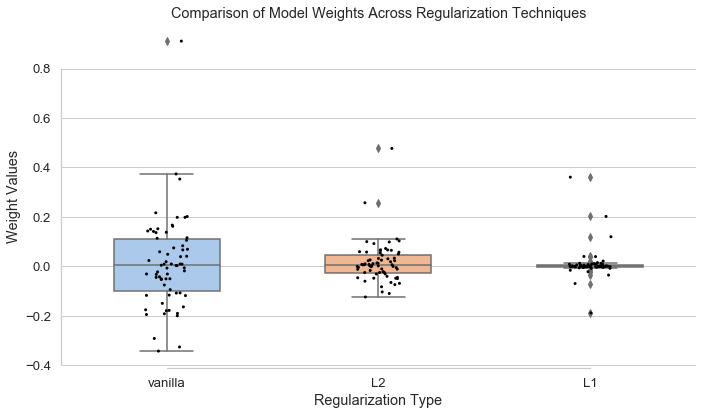

In [59]:
# Visualization & comparison of model parameters

weight_df = pd.DataFrame({
    'vanilla': weight.flatten(),  # Flatten in case the weights are in a 2D array or tensor
    'L2': weight_L2.flatten(),
    'L1': weight_L1.flatten()})

weight_df = weight_df.melt(var_name='Regularization', value_name='Weight')

# Visualization
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Regularization', y='Weight', data=weight_df, width=0.5)
sns.stripplot(x='Regularization', y='Weight', data=weight_df, color='black', size=3, jitter=True, ax=ax)

# Set the title and labels
ax.set_title('Comparison of Model Weights Across Regularization Techniques')
ax.set_xlabel('Regularization Type')
ax.set_ylabel('Weight Values')

sns.despine(trim=True)
plt.tight_layout()
plt.show()

In [60]:
# Proceed with the LASSO regression & Perform Genetic Algorithm for feature selection

lasso_weights = model_L2.linear.weight.detach().numpy().flatten()
selected_features = [feature for feature, weight in zip(features, lasso_weights) if weight != 0]
num_selected_features = len(selected_features)
print("Number of selected features:", num_selected_features)


Number of selected features: 67


In [61]:
# Perform GA

# Hyperparameters for GA
POPULATION_SIZE = 80
NUM_GENERATIONS = 50
CROSSOVER_PROBABILITY = 0.8
MUTATION_PROBABILITY = 0.1

# Convert PyTorch tensors to numpy arrays for sklearn compatibility
X_train_np = X_train.numpy()
y_train_np = y_train.numpy()
n_features = X_train_np.shape[1]

# Define the individual and population in DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the fitness function
def evalFitness(individual):
    # Subset features according to the individual's gene
    selected_features = [i for i in range(len(individual)) if individual[i] == 1]
    X_subset = X_train_np[:, selected_features]
    
    # Use logistic regression with the selected features to evaluate fitness
    clf = LogisticRegression(penalty='l1', solver='liblinear').fit(X_subset, y_train_np)
    y_pred = clf.predict_proba(X_subset)[:, 1]
    auroc = roc_auc_score(y_train_np, y_pred)

    # Penalize fitness for more features to encourage sparsity
    fitness = auroc - (0.2 * len(selected_features) / n_features)
    return (fitness,)

# Register the genetic operators
toolbox.register("evaluate", evalFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize the population
population = toolbox.population(n=POPULATION_SIZE)

# Run the GA
for gen in range(NUM_GENERATIONS):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CROSSOVER_PROBABILITY, mutpb=MUTATION_PROBABILITY)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Select the best individual after GA
best_individual = tools.selBest(population, k=1)[0]
selected_features = [i for i in range(len(best_individual)) if best_individual[i] == 1]


In [62]:
# One of the most, actually the first, exciting moments finally comes!

feature_names = features
selected_indices = [index for index in range(len(best_individual)) if best_individual[index] == 1]
selected_feature_names = [feature_names[index] for index in selected_indices]
print("Selected Features:")
for feature in selected_feature_names:
    print(feature)

Selected Features:
admission_age
heart_rate_max
dbp_min
mbp_max
resp_rate_max
bun_max
gcs_verbal
weight_admit


In [63]:
# Refit the logit model

# Convert indices list to a tensor for advanced indexing
selected_indices_tensor = torch.tensor(selected_indices, dtype=torch.long)

# Index the PyTorch tensor to select only the columns corresponding to the selected features
X_train_selected_tensor = X_train[:, selected_indices_tensor]


class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model_GA = LogisticRegressionModel(X_train_selected_tensor.shape[1])

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model_GA.parameters())  # Adam Optimizer

# Prepare K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
accuracies, auroc_scores, avg_precision_scores = [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X_train_selected_tensor)):
    # Split the data into training and validation sets for the current fold
    X_train_fold = X_train_selected_tensor[train_index]
    y_train_fold = y_train[train_index]
    X_test_fold = X_train_selected_tensor[test_index]
    y_test_fold = y_train[test_index]

    # Create DataLoaders for training and validation sets
    train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold.view(-1, 1)), batch_size=64, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_fold, y_test_fold.view(-1, 1)), batch_size=64, shuffle=False)

    # Training loop
    for epoch in range(10):  # You may want to adjust the number of epochs
        for X_batch, y_batch in train_loader:
            model_GA.train()
            optimizer.zero_grad()  # Clear gradients
            y_pred = model_GA(X_batch)  # Forward pass
            loss = criterion(y_pred, y_batch)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

    # Evaluation on the validation set
    model_GA.eval()
    with torch.no_grad():
        y_test_pred = model_GA(X_test_fold).squeeze()
        # Convert targets to binary classification format
        y_test_true = y_test_fold.squeeze()
        predictions = y_test_pred.round()

        # Calculate metrics
        accuracy = accuracy_score(y_test_true, predictions)
        auroc = roc_auc_score(y_test_true, y_test_pred)
        avg_precision = average_precision_score(y_test_true, y_test_pred)

        # Store metrics
        accuracies.append(accuracy)
        auroc_scores.append(auroc)
        avg_precision_scores.append(avg_precision)

    # Print metrics for the current fold
    print(f"Fold {fold}: Accuracy {accuracy}, AUROC {auroc}, Average Precision {avg_precision}")

# Calculate and print the mean metrics across all folds
mean_accuracy = np.mean(accuracies)
mean_auroc = np.mean(auroc_scores)
mean_avg_precision = np.mean(avg_precision_scores)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean AUROC: {mean_auroc}")
print(f"Mean Average Precision: {mean_avg_precision}")

Fold 0: Accuracy 0.6598298058040585, AUROC 0.7189089413818615, Average Precision 0.6847853045365941
Fold 1: Accuracy 0.6530656775038185, AUROC 0.7144741989096814, Average Precision 0.6796916955279177
Fold 2: Accuracy 0.6552476543748637, AUROC 0.7125820125749234, Average Precision 0.6721313950844777
Fold 3: Accuracy 0.6544462629569012, AUROC 0.7221082900791462, Average Precision 0.6859076281533244
Fold 4: Accuracy 0.6558647026732133, AUROC 0.717998829396578, Average Precision 0.6799670734005727
Mean Accuracy: 0.655690820662571
Mean AUROC: 0.717214454468438
Mean Average Precision: 0.6804966193405774


In [64]:
weight_GA = model_GA.linear.weight.detach().clone()
print(selected_feature_names)
print(weight_GA)

['admission_age', 'heart_rate_max', 'dbp_min', 'mbp_max', 'resp_rate_max', 'bun_max', 'gcs_verbal', 'weight_admit']
tensor([[ 0.3629,  0.1846, -0.2176,  0.1021,  0.1331,  0.2428, -0.3273,  0.8453]])


In [65]:
## Tree - random forest & XGBoost

# Random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

# Define the parameter grid
param_grid = {
    'max_depth':np.arange(start=2,stop=8,step=1),
    'n_estimators':np.arange(start=2,stop=20,step=2)}


# Initialize the classifier with entropy criterion
rf = RandomForestClassifier(criterion='entropy', bootstrap=True, random_state=42)

# Define the scoring function
scorer = make_scorer(roc_auc_score)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5)

# Fit the model
grid_search.fit(X_train_np, y_train_np)

# Best model after grid search
best_rf = grid_search.best_estimator_

print("Best parameters found: ", grid_search.best_params_)
print("Best AUROC found: ", grid_search.best_score_)


Best parameters found:  {'max_depth': 7, 'n_estimators': 18}
Best AUROC found:  0.7307976849180204


In [66]:
# Report the top 10 important features

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(10): 
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print("Feature name:", feature_names[indices[f]]) 

from sklearn.model_selection import cross_val_score

# Accuracy
accuracy_scores = cross_val_score(best_rf, X_train_np, y_train_np, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))

# AUROC
auroc_scores = cross_val_score(best_rf, X_train_np, y_train_np, cv=5, scoring='roc_auc')
print("AUROC: %0.2f (+/- %0.2f)" % (auroc_scores.mean(), auroc_scores.std() * 2))

# Average Precision
ap_scores = cross_val_score(best_rf, X_train_np, y_train_np, cv=5, scoring='average_precision')
print("Average Precision: %0.2f (+/- %0.2f)" % (ap_scores.mean(), ap_scores.std() * 2))

Feature ranking:
1. feature 61 (0.121047)
Feature name: weight_admit
2. feature 39 (0.108695)
Feature name: bun_max
3. feature 58 (0.071386)
Feature name: gcs_verbal
4. feature 1 (0.068282)
Feature name: admission_age
5. feature 38 (0.058162)
Feature name: bun_min
6. feature 5 (0.044130)
Feature name: sbp_min
7. feature 8 (0.036965)
Feature name: dbp_min
8. feature 53 (0.027935)
Feature name: pt_max
9. feature 59 (0.024320)
Feature name: gcs_eyes
10. feature 50 (0.024154)
Feature name: inr_min
Accuracy: 0.66 (+/- 0.01)
AUROC: 0.73 (+/- 0.01)
Average Precision: 0.71 (+/- 0.01)


In [99]:
# XGBoost

import xgboost as xgb

# Define XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid
param_grid = {
    'max_depth':np.arange(start=2,stop=6,step=1),
    'n_estimators':np.arange(start=2,stop=20,step=2),
    'learning_rate':np.arange(start=0.05,stop=0.4,step=0.05)}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_np, y_train_np)

# Get the best parameters and model
best_params_xgb = grid_search.best_params_
best_model_xgb = grid_search.best_estimator_

print("Best parameters found: ", best_params_xgb)


Fitting 5 folds for each of 252 candidates, totalling 1260 fits


KeyboardInterrupt: 

In [68]:
# Report the top 10 important features

importances = best_model_xgb.feature_importances_
indices = np.argsort(importances)[::-1][:10]
print("Top 10 important features:")
for f in range(10): 
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print("Feature name:", feature_names[indices[f]]) 


# Accuracy
accuracy_scores = cross_val_score(best_model_xgb, X_train_np, y_train_np, cv=5, scoring='accuracy')
print(f"Mean Accuracy: {np.mean(accuracy_scores)}")

# AUROC
auroc_scores = cross_val_score(best_model_xgb, X_train_np, y_train_np, cv=5, scoring='roc_auc')
print(f"Mean AUROC: {np.mean(auroc_scores)}")

# Average Precision (AP)
ap_scores = cross_val_score(best_model_xgb, X_train_np, y_train_np, cv=5, scoring='average_precision')
print(f"Mean AP: {np.mean(ap_scores)}")


Top 10 important features:
1. feature 39 (0.136148)
Feature name: bun_max
2. feature 58 (0.053113)
Feature name: gcs_verbal
3. feature 1 (0.041942)
Feature name: admission_age
4. feature 51 (0.038729)
Feature name: inr_max
5. feature 5 (0.038541)
Feature name: sbp_min
6. feature 61 (0.037237)
Feature name: weight_admit
7. feature 49 (0.036583)
Feature name: potassium_max.1
8. feature 59 (0.033545)
Feature name: gcs_eyes
9. feature 8 (0.028859)
Feature name: dbp_min
10. feature 3 (0.020921)
Feature name: heart_rate_max
Mean Accuracy: 0.6815703829196803
Mean AUROC: 0.7511747594042367
Mean AP: 0.7267918024742217


In [69]:
# SVM - linear SVM + kernel for nonlinear-seperable

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Define the model with L2 penalty
svm_model = LinearSVC(dual=False, random_state=42, max_iter=10000)

# Define the range for the regularization parameter 'C'
param_grid = {'C': np.arange(start=1,stop=20,step=5)}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_np, y_train_np)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)
print("Best model: ", best_model)

# Feature selection can be observed from the non-zero coefficients of the best model
non_zero_indices = np.where(best_model.coef_ != 0)[1]
selected_features = [features[i] for i in non_zero_indices]

print("Selected features", selected_features)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'C': 16}
Best model:  LinearSVC(C=16, dual=False, max_iter=10000, random_state=42)
Selected features ['gender', 'admission_age', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'dbp_max', 'dbp_mean', 'mbp_min', 'mbp_max', 'mbp_mean', 'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'temperature_min', 'temperature_max', 'temperature_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'hematocrit_min.1', 'hematocrit_max.1', 'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min', 'platelets_max', 'wbc_min', 'wbc_max', 'aniongap_min', 'aniongap_max', 'bicarbonate_min.1', 'bicarbonate_max.1', 'bun_min', 'bun_max', 'calcium_min.1', 'calcium_max.1', 'chloride_min.1', 'chloride_max.1', 'glucose_min.2', 'glucose_max.2', 'sodium_min.1', 'sodium_max.1', 'potassium_min.1', 'potassium_max.1', 'inr_min', 'inr_max', 'pt_min'

In [70]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate performance metrics using cross-validation
accuracy_scores = cross_val_score(svm_model, X_train_np, y_train_np, cv=cv, scoring='accuracy')
auroc_scores = cross_val_score(svm_model, X_train_np, y_train_np, cv=cv, scoring='roc_auc')
ap_scores = cross_val_score(svm_model, X_train_np, y_train_np, cv=cv, scoring='average_precision')

# Print the mean of the scores
print(f"Mean Accuracy: {accuracy_scores.mean()}")
print(f"Mean AUROC: {auroc_scores.mean()}")
print(f"Mean Average Precision: {ap_scores.mean()}")

Mean Accuracy: 0.6724492243982869
Mean AUROC: 0.7382841012034623
Mean Average Precision: 0.7065922592444498


In [71]:
# Perform GA

# Hyperparameters for GA
POPULATION_SIZE = 80
NUM_GENERATIONS = 40
CROSSOVER_PROBABILITY = 0.8
MUTATION_PROBABILITY = 0.1

# Define the individual and population in DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def eval_fitness(individual):
    # Subset features according to the individual's gene
    selected_features = [i for i in range(len(individual)) if individual[i] == 1]
    X_subset = X_train_np[:, selected_features]

    # Use linear SVM with the selected features to evaluate fitness
    clf = SVC(kernel='linear').fit(X_subset, y_train_np)
    y_pred = clf.predict(X_subset)
    
    # It's common to use accuracy as the fitness for feature selection with SVM
    accuracy = accuracy_score(y_train_np, y_pred)

    # Penalize fitness for more features to encourage sparsity
    fitness = accuracy - (0.2 * len(selected_features) / n_features)
    return (fitness,)


# Register the genetic operators
toolbox.register("evaluate", evalFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize the population
population = toolbox.population(n=POPULATION_SIZE)

# Run the GA
for gen in range(NUM_GENERATIONS):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CROSSOVER_PROBABILITY, mutpb=MUTATION_PROBABILITY)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Select the best individual after GA
best_individual = tools.selBest(population, k=1)[0]
selected_features = [i for i in range(len(best_individual)) if best_individual[i] == 1]

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [72]:
feature_names = features
selected_indices_1 = [index for index in range(len(best_individual)) if best_individual[index] == 1]
selected_feature_names = [feature_names[index] for index in selected_indices_1]
print("Selected Features:")
for feature in selected_feature_names:
    print(feature)

Selected Features:
admission_age
mbp_min
resp_rate_mean
bun_max
calcium_min.1
gcs_verbal
weight_admit


In [73]:
#Re-fit the data with features selected from GA using linear SVM

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, average_precision_score

# Subset the training data to only use the selected features
X_selected = X_train_np[:, selected_indices_1]

# Initialize the parameter grid for C
param_grid = {'C': np.arange(start=1, stop=20, step=1)}

# Initialize the linear SVM model
svm_model_f = LinearSVC(dual=False, random_state=42)

# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to find the optimal C
grid_search = GridSearchCV(svm_model_f, param_grid, scoring='roc_auc', cv=cv_strategy, verbose=1)
grid_search.fit(X_selected, y_train_np)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print out the best parameter for C
print(f"Best 'C' parameter found: {best_params['C']}")

# Calculate cross-validated scores with the best model
accuracy_scores = cross_val_score(best_model, X_selected, y_train_np, cv=cv_strategy, scoring='accuracy')
auroc_scores = cross_val_score(best_model, X_selected, y_train_np, cv=cv_strategy, scoring='roc_auc')
precision_scores = cross_val_score(best_model, X_selected, y_train_np, cv=cv_strategy, scoring='average_precision')

# Print out the mean scores
print(f"Mean Accuracy with best C: {accuracy_scores.mean()}")
print(f"Mean AUROC with best C: {auroc_scores.mean()}")
print(f"Mean Average Precision with best C: {precision_scores.mean()}")


Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best 'C' parameter found: 10
Mean Accuracy with best C: 0.6518722373381357
Mean AUROC with best C: 0.7130580754669136
Mean Average Precision with best C: 0.6779604778774917


In [74]:
# Baseline non-linear SVM model

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


# Initialize SVM with RBF kernel
svc_rbf = SVC(kernel='rbf', gamma='scale')

# Parameters for grid search (using powers of 10 to cover a wide range)
param_grid = {'C':np.arange(0.5,5,step=1.0)}

# Set up the grid search with 2-fold cross-validation for faster computation
grid_search = GridSearchCV(svc_rbf, param_grid, cv=4, scoring='roc_auc', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_np, y_train_np)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)


Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'C': 0.5}


In [75]:
# Cross-validation to calculate scores
accuracy = cross_val_score(best_model, X_train_np, y_train_np, cv=5, scoring='accuracy').mean()
auroc = cross_val_score(best_model, X_train_np, y_train_np, cv=5, scoring='roc_auc').mean()
average_precision = cross_val_score(best_model, X_train_np, y_train_np, cv=5, scoring='average_precision').mean()

# Print results
print(f'Accuracy: {accuracy}')
print(f'AUROC: {auroc}')
print(f'Average Precision: {average_precision}')

KeyboardInterrupt: 

In [ ]:
## Validation of model performance in unseen data

In [100]:
# Performance of XGBoost

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix

# Make predictions on the validation data
y_pred_probs = best_model_xgb.predict_proba(X_validation_np)[:, 1]  # get the probability of class 1
y_pred = best_model_xgb.predict(X_validation_np)

# Calculate AUROC
auroc = roc_auc_score(y_validation_np, y_pred_probs)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_validation_np, y_pred, average='binary')

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_validation_np, y_pred)

# Print the evaluation metrics
print(f'Validation AUROC: {auroc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')



Validation AUROC: 0.7470596454097903
Precision: 0.6575225032147449
Recall: 0.6491747778247989
F1-Score: 0.6533219761499147
Confusion Matrix:
 [[1930  799]
 [ 829 1534]]


In [ ]:
# Performance of non-linear SVM

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix

if not hasattr(best_model, "predict_proba"):
    best_model.probability = True
    best_model.fit(X_train_np, y_train_np)  # Retrain with probability estimates enabled

# Make predictions on the validation data
y_pred_probs = best_model.predict_proba(X_validation_np)[:, 1]  # Probability estimates for the positive class
y_pred = best_model.predict(X_validation_np)

# Calculate AUROC
auroc = roc_auc_score(y_validation_np, y_pred_probs)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_validation_np, y_pred, average='binary')

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_validation_np, y_pred)

# Print the evaluation metrics
print(f'Validation AUROC: {auroc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
